In [1]:
# Cell 1: Import All Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import pickle
from datetime import datetime

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_recall_fscore_support,
                             roc_auc_score, roc_curve)

# Baseline Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

# Text Processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Handle Imbalance
from imblearn.over_sampling import SMOTE

# Progress bars
from tqdm import tqdm

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*70)
print(" " * 20 + "✅ ALL LIBRARIES IMPORTED SUCCESSFULLY!")
print("="*70)
print(f"\nNotebook Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

                    ✅ ALL LIBRARIES IMPORTED SUCCESSFULLY!

Notebook Started: 2026-02-10 09:45:12


In [2]:
# Cell 2: Load Both Datasets
print("="*70)
print(" " * 25 + "LOADING DATASETS")
print("="*70)

# Load Kaggle dataset
kaggle_path = '../data/raw/Lifestyle_and_Health_Risk_Prediction_Synthetic_Dataset Kaggle.csv'
df_kaggle = pd.read_csv(kaggle_path)
print(f"\n✅ Kaggle Dataset Loaded:")
print(f"   Shape: {df_kaggle.shape}")
print(f"   Columns: {df_kaggle.columns.tolist()}")

# Load preprocessed Reddit dataset
reddit_path = '../data/processed/preprocessed_data.csv'
df_reddit = pd.read_csv(reddit_path)
print(f"\n✅ Reddit Dataset Loaded:")
print(f"   Shape: {df_reddit.shape}")
print(f"   Key columns: {['cleaned_text', 'health_category', 'lexical_diversity']}")

print("\n" + "="*70)
print("DATASET SUMMARY:")
print("="*70)
print(f"Kaggle Records: {len(df_kaggle):,}")
print(f"Reddit Records: {len(df_reddit):,}")
print(f"Total Data Points: {len(df_kaggle) + len(df_reddit):,}")

                         LOADING DATASETS

✅ Kaggle Dataset Loaded:
   Shape: (5000, 12)
   Columns: ['age', 'weight', 'height', 'exercise', 'sleep', 'sugar_intake', 'smoking', 'alcohol', 'married', 'profession', 'bmi', 'health_risk']

✅ Reddit Dataset Loaded:
   Shape: (19060, 19)
   Key columns: ['cleaned_text', 'health_category', 'lexical_diversity']

DATASET SUMMARY:
Kaggle Records: 5,000
Reddit Records: 19,060
Total Data Points: 24,060


In [3]:
# Cell 3: Preprocess Kaggle Dataset
print("="*70)
print(" " * 20 + "PREPROCESSING KAGGLE DATASET")
print("="*70)

# Create a copy
df_kaggle_processed = df_kaggle.copy()

# 1. Create binary target (high=1, low=0)
df_kaggle_processed['risk_binary'] = (df_kaggle_processed['health_risk'] == 'high').astype(int)

print(f"\n✅ Target Variable Created:")
print(df_kaggle_processed['risk_binary'].value_counts())
print(f"   Class Balance: {df_kaggle_processed['risk_binary'].value_counts(normalize=True).to_dict()}")

# 2. Encode categorical variables
categorical_cols = ['exercise', 'sugar_intake', 'smoking', 'alcohol', 'married', 'profession']

print(f"\n✅ Encoding Categorical Features:")
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_kaggle_processed[f'{col}_encoded'] = le.fit_transform(df_kaggle_processed[col])
    label_encoders[col] = le
    print(f"   {col}: {df_kaggle_processed[col].nunique()} categories → encoded")

# Save encoders for later use
joblib.dump(label_encoders, '../models/label_encoders.pkl')
print(f"\n✅ Label encoders saved to: ../models/label_encoders.pkl")

# 3. Feature Engineering
print(f"\n✅ Feature Engineering:")

# Age groups
df_kaggle_processed['age_group'] = pd.cut(df_kaggle_processed['age'], 
                                            bins=[0, 30, 50, 100], 
                                            labels=[0, 1, 2])

# Sleep quality (good sleep = 7-9 hours)
df_kaggle_processed['sleep_quality'] = ((df_kaggle_processed['sleep'] >= 7) & 
                                         (df_kaggle_processed['sleep'] <= 9)).astype(int)

# Substance use flag
df_kaggle_processed['substance_use'] = ((df_kaggle_processed['smoking'] == 'yes') | 
                                         (df_kaggle_processed['alcohol'] == 'yes')).astype(int)

# Lifestyle score (combination of positive factors)
df_kaggle_processed['lifestyle_score'] = (
    (df_kaggle_processed['exercise'].isin(['medium', 'high'])).astype(int) +
    (df_kaggle_processed['sleep_quality'] == 1).astype(int) +
    (df_kaggle_processed['sugar_intake'] == 'low').astype(int) +
    (df_kaggle_processed['smoking'] == 'no').astype(int) +
    (df_kaggle_processed['alcohol'] == 'no').astype(int)
)

print(f"   - age_group created (3 groups)")
print(f"   - sleep_quality created (binary)")
print(f"   - substance_use flag created")
print(f"   - lifestyle_score created (0-5 scale)")

# 4. Select features for modeling
feature_cols = [
    'age', 'weight', 'height', 'sleep', 'bmi',
    'exercise_encoded', 'sugar_intake_encoded', 
    'smoking_encoded', 'alcohol_encoded', 'married_encoded',
    'age_group', 'sleep_quality', 'substance_use', 'lifestyle_score'
]

X_kaggle = df_kaggle_processed[feature_cols]
y_kaggle = df_kaggle_processed['risk_binary']

print(f"\n✅ Feature Matrix Created:")
print(f"   Shape: {X_kaggle.shape}")
print(f"   Features: {len(feature_cols)}")

# Display feature importance preview
print(f"\n📊 Feature Statistics:")
print(X_kaggle.describe())

                    PREPROCESSING KAGGLE DATASET

✅ Target Variable Created:
risk_binary
1    3490
0    1510
Name: count, dtype: int64
   Class Balance: {1: 0.698, 0: 0.302}

✅ Encoding Categorical Features:
   exercise: 4 categories → encoded
   sugar_intake: 3 categories → encoded
   smoking: 2 categories → encoded
   alcohol: 2 categories → encoded
   married: 2 categories → encoded
   profession: 8 categories → encoded

✅ Label encoders saved to: ../models/label_encoders.pkl

✅ Feature Engineering:
   - age_group created (3 groups)
   - sleep_quality created (binary)
   - substance_use flag created
   - lifestyle_score created (0-5 scale)

✅ Feature Matrix Created:
   Shape: (5000, 14)
   Features: 14

📊 Feature Statistics:
               age       weight       height        sleep         bmi  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.00000   
mean     48.805600    77.359200   171.933200     6.997060    26.84388   
std      17.906991    18.714567    15.82222

In [4]:
# Cell 4: Split Kaggle Data (Stratified)
print("="*70)
print(" " * 20 + "TRAIN-TEST SPLIT (KAGGLE)")
print("="*70)

# Stratified split to maintain class balance
X_train_kg, X_test_kg, y_train_kg, y_test_kg = train_test_split(
    X_kaggle, y_kaggle, 
    test_size=0.2, 
    stratify=y_kaggle,
    random_state=42
)

print(f"\n✅ Data Split Complete:")
print(f"   Training Set: {X_train_kg.shape[0]:,} samples")
print(f"   Test Set: {X_test_kg.shape[0]:,} samples")

print(f"\n📊 Class Distribution in Train:")
print(y_train_kg.value_counts())
print(f"   Balance: {y_train_kg.value_counts(normalize=True).to_dict()}")

print(f"\n📊 Class Distribution in Test:")
print(y_test_kg.value_counts())
print(f"   Balance: {y_test_kg.value_counts(normalize=True).to_dict()}")

# Scale features
scaler = StandardScaler()
X_train_kg_scaled = scaler.fit_transform(X_train_kg)
X_test_kg_scaled = scaler.transform(X_test_kg)

# Save scaler
joblib.dump(scaler, '../models/kaggle_scaler.pkl')
print(f"\n✅ Feature scaler saved to: ../models/kaggle_scaler.pkl")

                    TRAIN-TEST SPLIT (KAGGLE)

✅ Data Split Complete:
   Training Set: 4,000 samples
   Test Set: 1,000 samples

📊 Class Distribution in Train:
risk_binary
1    2792
0    1208
Name: count, dtype: int64
   Balance: {1: 0.698, 0: 0.302}

📊 Class Distribution in Test:
risk_binary
1    698
0    302
Name: count, dtype: int64
   Balance: {1: 0.698, 0: 0.302}

✅ Feature scaler saved to: ../models/kaggle_scaler.pkl


In [5]:
# Cell 5: Apply SMOTE to Handle Imbalance
print("="*70)
print(" " * 20 + "HANDLING CLASS IMBALANCE (SMOTE)")
print("="*70)

print(f"\n📊 Before SMOTE:")
print(f"   Class 0 (Low Risk): {(y_train_kg == 0).sum():,}")
print(f"   Class 1 (High Risk): {(y_train_kg == 1).sum():,}")
print(f"   Ratio: {(y_train_kg == 0).sum() / (y_train_kg == 1).sum():.3f}")

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_kg_balanced, y_train_kg_balanced = smote.fit_resample(X_train_kg_scaled, y_train_kg)

print(f"\n📊 After SMOTE:")
print(f"   Class 0 (Low Risk): {(y_train_kg_balanced == 0).sum():,}")
print(f"   Class 1 (High Risk): {(y_train_kg_balanced == 1).sum():,}")
print(f"   Ratio: {(y_train_kg_balanced == 0).sum() / (y_train_kg_balanced == 1).sum():.3f}")

print(f"\n✅ SMOTE applied successfully!")
print(f"   Original training samples: {len(y_train_kg):,}")
print(f"   Balanced training samples: {len(y_train_kg_balanced):,}")
print(f"   Additional synthetic samples: {len(y_train_kg_balanced) - len(y_train_kg):,}")

                    HANDLING CLASS IMBALANCE (SMOTE)

📊 Before SMOTE:
   Class 0 (Low Risk): 1,208
   Class 1 (High Risk): 2,792
   Ratio: 0.433

📊 After SMOTE:
   Class 0 (Low Risk): 2,792
   Class 1 (High Risk): 2,792
   Ratio: 1.000

✅ SMOTE applied successfully!
   Original training samples: 4,000
   Balanced training samples: 5,584
   Additional synthetic samples: 1,584


In [6]:
# Cell 6: Define Evaluation Functions
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Comprehensive model evaluation with multiple metrics
    """
    print("="*70)
    print(f" " * 20 + f"EVALUATING: {model_name}")
    print("="*70)
    
    # Training predictions
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    # Test predictions
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Detailed metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
    
    # ROC-AUC
    if hasattr(model, 'predict_proba'):
        y_test_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_test_proba)
    else:
        roc_auc = None
    
    # Print results
    print(f"\n📊 Performance Metrics:")
    print(f"   Training Accuracy: {train_accuracy:.4f}")
    print(f"   Test Accuracy: {test_accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    if roc_auc:
        print(f"   ROC-AUC: {roc_auc:.4f}")
    
    # Classification Report
    print(f"\n📋 Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=['Low Risk', 'High Risk']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    
    # Visualize Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Low Risk', 'High Risk'],
                yticklabels=['Low Risk', 'High Risk'],
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix: {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    # Save confusion matrix
    safe_name = model_name.replace(' ', '_').replace('/', '_').lower()
    plt.savefig(f'../reports/cm_{safe_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Return metrics dictionary
    return {
        'model_name': model_name,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

print("✅ Evaluation functions defined successfully!")

✅ Evaluation functions defined successfully!


               BASELINE MODEL 1: LOGISTIC REGRESSION

🔄 Training Logistic Regression...
✅ Training complete!
                    EVALUATING: Logistic Regression (Kaggle)

📊 Performance Metrics:
   Training Accuracy: 0.8805
   Test Accuracy: 0.8680
   Precision: 0.8794
   Recall: 0.8680
   F1-Score: 0.8708
   ROC-AUC: 0.9485

📋 Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.74      0.87      0.80       302
   High Risk       0.94      0.87      0.90       698

    accuracy                           0.87      1000
   macro avg       0.84      0.87      0.85      1000
weighted avg       0.88      0.87      0.87      1000



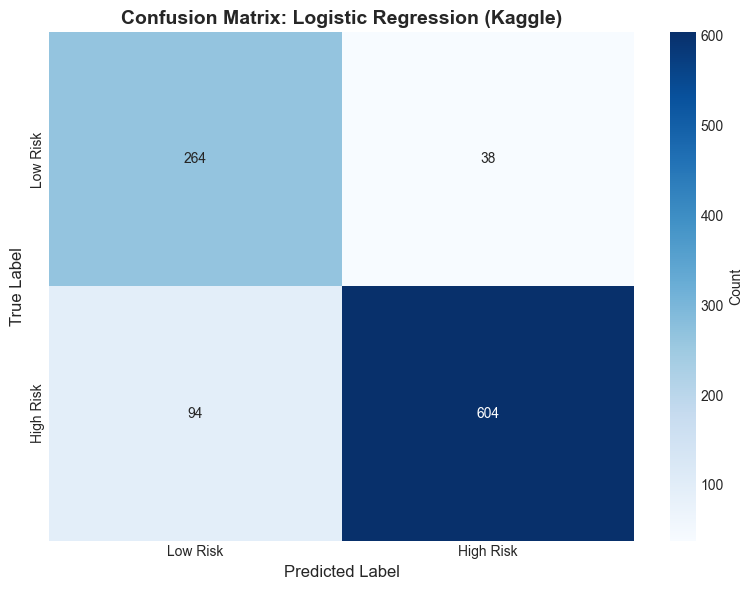


✅ Model saved to: ../models/kaggle_logistic_regression.pkl

📊 Top 10 Most Important Features (by coefficient):
             feature  coefficient
     lifestyle_score    -2.166448
     smoking_encoded     1.604841
           age_group     1.467756
              weight     1.423388
sugar_intake_encoded    -1.123212
       sleep_quality     0.952541
              height    -0.862571
     alcohol_encoded     0.827713
                 age     0.792564
               sleep    -0.729395


In [7]:
# Cell 7: Train Logistic Regression (Baseline)
print("="*70)
print(" " * 15 + "BASELINE MODEL 1: LOGISTIC REGRESSION")
print("="*70)

# Initialize model
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',  # Handle imbalance
    solver='lbfgs'
)

# Train model
print("\n🔄 Training Logistic Regression...")
lr_model.fit(X_train_kg_scaled, y_train_kg)
print("✅ Training complete!")

# Evaluate
lr_metrics = evaluate_model(
    lr_model, 
    X_train_kg_scaled, y_train_kg,
    X_test_kg_scaled, y_test_kg,
    "Logistic Regression (Kaggle)"
)

# Save model
joblib.dump(lr_model, '../models/kaggle_logistic_regression.pkl')
print(f"\n✅ Model saved to: ../models/kaggle_logistic_regression.pkl")

# Feature coefficients (importance)
feature_importance_lr = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print(f"\n📊 Top 10 Most Important Features (by coefficient):")
print(feature_importance_lr.head(10).to_string(index=False))

               BASELINE MODEL 2: RANDOM FOREST

🔄 Training Random Forest...
✅ Training complete!
                    EVALUATING: Random Forest (Kaggle)

📊 Performance Metrics:
   Training Accuracy: 0.9915
   Test Accuracy: 0.9700
   Precision: 0.9704
   Recall: 0.9700
   F1-Score: 0.9701
   ROC-AUC: 0.9964

📋 Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.94      0.96      0.95       302
   High Risk       0.98      0.97      0.98       698

    accuracy                           0.97      1000
   macro avg       0.96      0.97      0.96      1000
weighted avg       0.97      0.97      0.97      1000



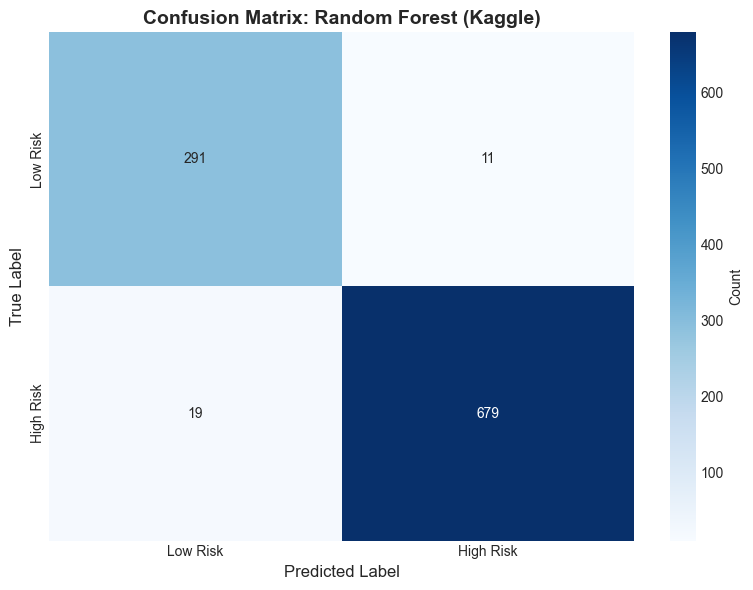


✅ Model saved to: ../models/kaggle_random_forest.pkl

📊 Top 10 Most Important Features:
             feature  importance
                 bmi    0.193722
                 age    0.152922
           age_group    0.137082
     lifestyle_score    0.100460
              weight    0.077247
               sleep    0.069585
       substance_use    0.060449
sugar_intake_encoded    0.057066
     smoking_encoded    0.046631
    exercise_encoded    0.039955


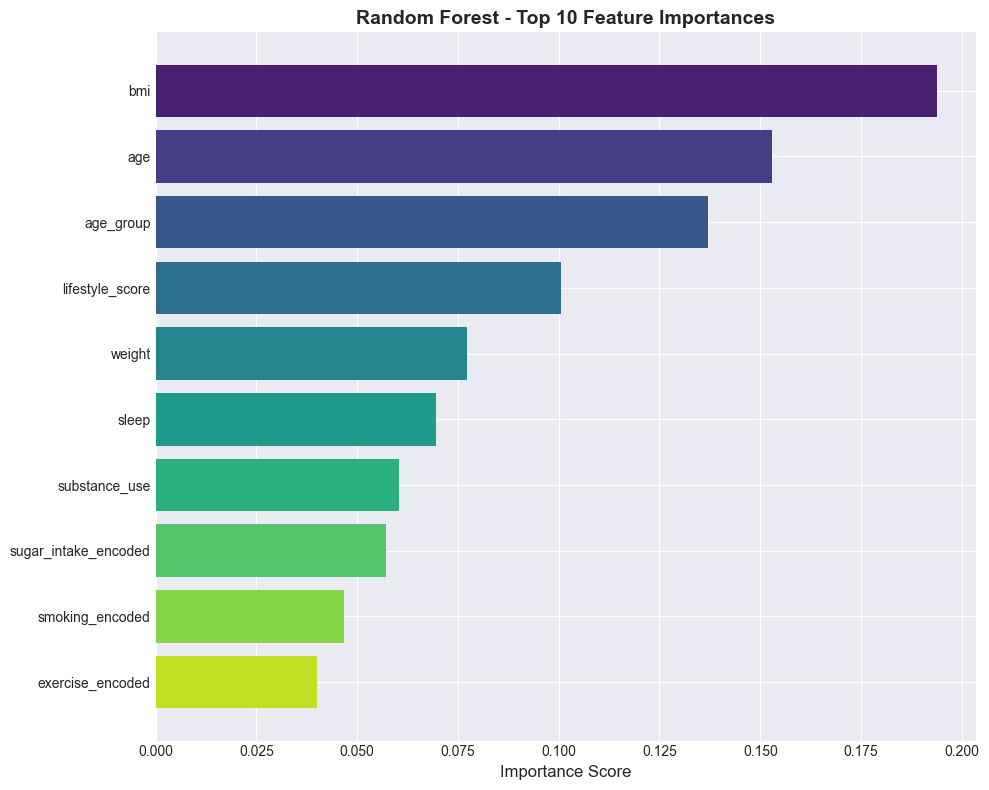

In [8]:
# Cell 8: Train Random Forest (Baseline)
print("="*70)
print(" " * 15 + "BASELINE MODEL 2: RANDOM FOREST")
print("="*70)

# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Train model
print("\n🔄 Training Random Forest...")
rf_model.fit(X_train_kg_scaled, y_train_kg)
print("✅ Training complete!")

# Evaluate
rf_metrics = evaluate_model(
    rf_model,
    X_train_kg_scaled, y_train_kg,
    X_test_kg_scaled, y_test_kg,
    "Random Forest (Kaggle)"
)

# Save model
joblib.dump(rf_model, '../models/kaggle_random_forest.pkl')
print(f"\n✅ Model saved to: ../models/kaggle_random_forest.pkl")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n📊 Top 10 Most Important Features:")
print(feature_importance_rf.head(10).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importance_rf.head(10))), 
         feature_importance_rf.head(10)['importance'],
         color=sns.color_palette("viridis", 10))
plt.yticks(range(10), feature_importance_rf.head(10)['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Random Forest - Top 10 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../reports/rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

               BASELINE MODEL 3: XGBoost

🔄 Training XGBoost...
✅ Training complete!
                    EVALUATING: XGBoost (Kaggle)

📊 Performance Metrics:
   Training Accuracy: 0.9998
   Test Accuracy: 0.9960
   Precision: 0.9960
   Recall: 0.9960
   F1-Score: 0.9960
   ROC-AUC: 0.9998

📋 Classification Report:
              precision    recall  f1-score   support

    Low Risk       1.00      0.99      0.99       302
   High Risk       0.99      1.00      1.00       698

    accuracy                           1.00      1000
   macro avg       1.00      0.99      1.00      1000
weighted avg       1.00      1.00      1.00      1000



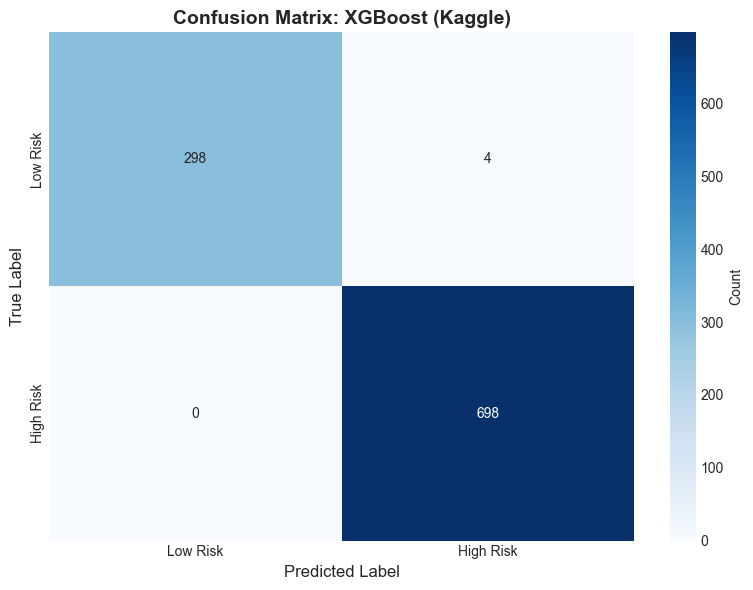


✅ Model saved to: ../models/kaggle_xgboost.pkl

📊 Top 10 Most Important Features:
             feature  importance
           age_group    0.267242
                 bmi    0.159365
       substance_use    0.101720
                 age    0.083059
     smoking_encoded    0.080843
     lifestyle_score    0.057855
       sleep_quality    0.046616
sugar_intake_encoded    0.045270
    exercise_encoded    0.042044
               sleep    0.040662


In [9]:
# Cell 9: Train XGBoost (Advanced Baseline)
print("="*70)
print(" " * 15 + "BASELINE MODEL 3: XGBoost")
print("="*70)

# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y_train_kg == 0).sum() / (y_train_kg == 1).sum()

# Initialize model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

# Train model
print("\n🔄 Training XGBoost...")
xgb_model.fit(X_train_kg_scaled, y_train_kg)
print("✅ Training complete!")

# Evaluate
xgb_metrics = evaluate_model(
    xgb_model,
    X_train_kg_scaled, y_train_kg,
    X_test_kg_scaled, y_test_kg,
    "XGBoost (Kaggle)"
)

# Save model
joblib.dump(xgb_model, '../models/kaggle_xgboost.pkl')
print(f"\n✅ Model saved to: ../models/kaggle_xgboost.pkl")

# Feature importance
feature_importance_xgb = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n📊 Top 10 Most Important Features:")
print(feature_importance_xgb.head(10).to_string(index=False))

               CROSS-VALIDATION ANALYSIS

🔄 Running 5-Fold Cross-Validation...

   Evaluating Logistic Regression...
   ✅ Logistic Regression:
      Mean Accuracy: 0.8773 (+/- 0.0076)
      Individual Folds: [0.86375 0.87625 0.88375 0.8775  0.885  ]

   Evaluating Random Forest...
   ✅ Random Forest:
      Mean Accuracy: 0.9752 (+/- 0.0038)
      Individual Folds: [0.98125 0.97125 0.9775  0.97125 0.975  ]

   Evaluating XGBoost...
   ✅ XGBoost:
      Mean Accuracy: 0.9953 (+/- 0.0024)
      Individual Folds: [0.9975  0.9975  0.99375 0.99125 0.99625]



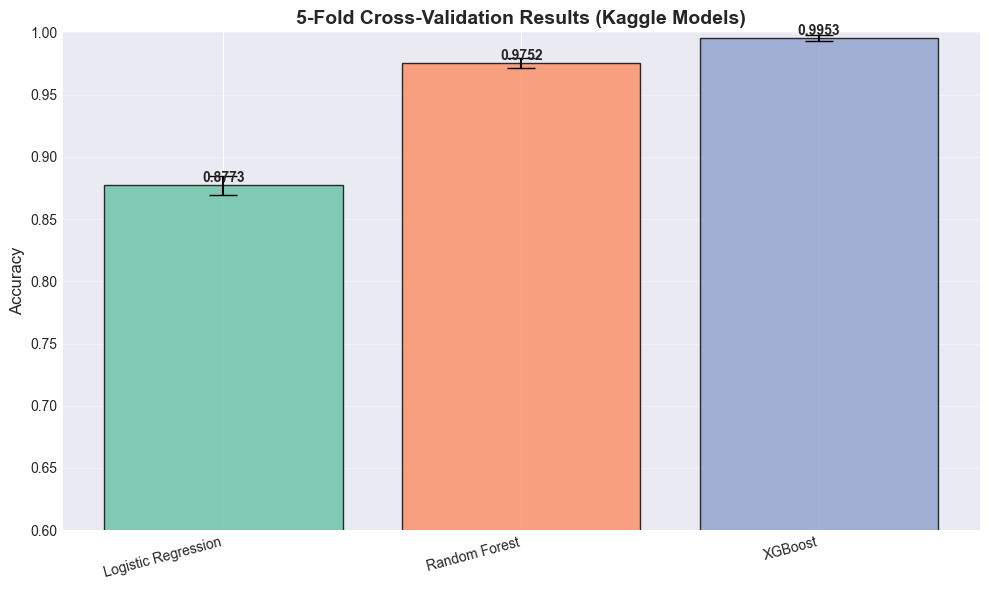


🏆 Best Kaggle Model (by CV): XGBoost
   Mean Accuracy: 0.9953


In [10]:
# Cell 10: Cross-Validation Comparison
print("="*70)
print(" " * 15 + "CROSS-VALIDATION ANALYSIS")
print("="*70)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_to_cv = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}

cv_results = {}

print("\n🔄 Running 5-Fold Cross-Validation...\n")

for name, model in models_to_cv.items():
    print(f"   Evaluating {name}...")
    scores = cross_val_score(model, X_train_kg_scaled, y_train_kg, 
                             cv=cv, scoring='accuracy', n_jobs=-1)
    
    cv_results[name] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'scores': scores
    }
    
    print(f"   ✅ {name}:")
    print(f"      Mean Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
    print(f"      Individual Folds: {scores}")
    print()

# Visualize CV results
fig, ax = plt.subplots(figsize=(10, 6))

positions = range(len(cv_results))
means = [cv_results[name]['mean'] for name in cv_results]
stds = [cv_results[name]['std'] for name in cv_results]
names = list(cv_results.keys())

bars = ax.bar(positions, means, yerr=stds, 
              color=sns.color_palette("Set2", len(names)),
              capsize=10, alpha=0.8, edgecolor='black')

ax.set_xticks(positions)
ax.set_xticklabels(names, rotation=15, ha='right')
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('5-Fold Cross-Validation Results (Kaggle Models)', 
             fontsize=14, fontweight='bold')
ax.set_ylim(0.6, 1.0)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, mean) in enumerate(zip(bars, means)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mean:.4f}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/kaggle_cv_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Determine best model
best_model_name = max(cv_results, key=lambda x: cv_results[x]['mean'])
print(f"\n🏆 Best Kaggle Model (by CV): {best_model_name}")
print(f"   Mean Accuracy: {cv_results[best_model_name]['mean']:.4f}")

               HYPERPARAMETER TUNING

🔄 Tuning Random Forest with GridSearchCV...
   (This may take a few minutes...)

Fitting 3 folds for each of 24 candidates, totalling 72 fits

✅ GridSearch Complete!

🏆 Best Parameters:
   max_depth: 12
   min_samples_leaf: 1
   min_samples_split: 2
   n_estimators: 200

📊 Best CV Score (F1-weighted): 0.9830
                    EVALUATING: Random Forest Tuned (Kaggle)

📊 Performance Metrics:
   Training Accuracy: 0.9990
   Test Accuracy: 0.9780
   Precision: 0.9780
   Recall: 0.9780
   F1-Score: 0.9780
   ROC-AUC: 0.9980

📋 Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.97      0.96      0.96       302
   High Risk       0.98      0.99      0.98       698

    accuracy                           0.98      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.98      0.98      0.98      1000



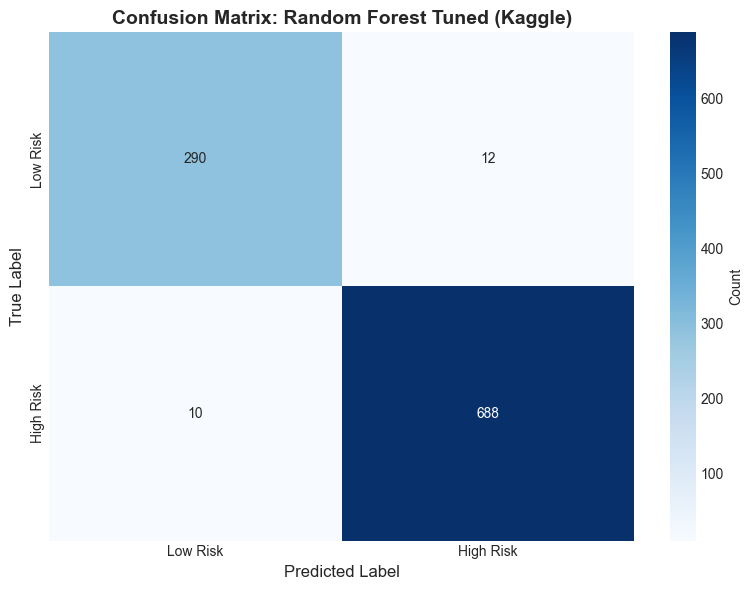


✅ Tuned model saved to: ../models/kaggle_random_forest_tuned.pkl


In [11]:
# Cell 11: Hyperparameter Tuning (GridSearchCV)
print("="*70)
print(" " * 15 + "HYPERPARAMETER TUNING")
print("="*70)

# We'll tune the best performing model (likely XGBoost or Random Forest)
# For demonstration, let's tune Random Forest

print("\n🔄 Tuning Random Forest with GridSearchCV...")
print("   (This may take a few minutes...)\n")

# Define parameter grid
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearch
grid_search_rf = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=3,  # 3-fold for speed
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearch
grid_search_rf.fit(X_train_kg_scaled, y_train_kg)

# Best parameters
print(f"\n✅ GridSearch Complete!")
print(f"\n🏆 Best Parameters:")
for param, value in grid_search_rf.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📊 Best CV Score (F1-weighted): {grid_search_rf.best_score_:.4f}")

# Train final model with best parameters
rf_tuned = grid_search_rf.best_estimator_

# Evaluate tuned model
rf_tuned_metrics = evaluate_model(
    rf_tuned,
    X_train_kg_scaled, y_train_kg,
    X_test_kg_scaled, y_test_kg,
    "Random Forest Tuned (Kaggle)"
)

# Save tuned model
joblib.dump(rf_tuned, '../models/kaggle_random_forest_tuned.pkl')
print(f"\n✅ Tuned model saved to: ../models/kaggle_random_forest_tuned.pkl")

               KAGGLE MODELS - PERFORMANCE SUMMARY

📊 Performance Comparison Table:
                  model_name  train_accuracy  test_accuracy  precision  recall  f1_score  roc_auc
Logistic Regression (Kaggle)          0.8805          0.868     0.8794   0.868    0.8708   0.9485
      Random Forest (Kaggle)          0.9915          0.970     0.9704   0.970    0.9701   0.9964
            XGBoost (Kaggle)          0.9998          0.996     0.9960   0.996    0.9960   0.9998
Random Forest Tuned (Kaggle)          0.9990          0.978     0.9780   0.978    0.9780   0.9980


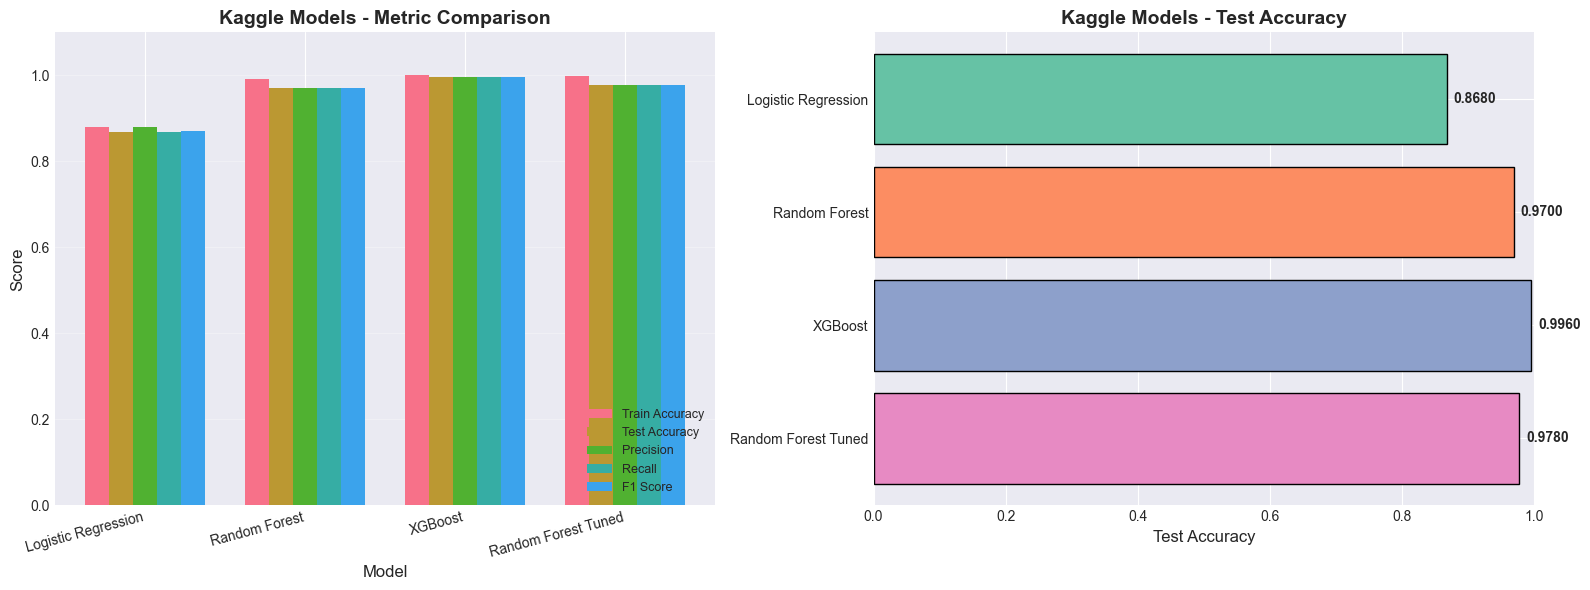


✅ Summary saved to: ../results/kaggle_models_summary.csv

🏆 BEST KAGGLE MODEL:
   Model: XGBoost (Kaggle)
   Test Accuracy: 0.9960

✅ Best model saved as: ../models/best_kaggle_model.pkl


In [12]:
# Cell 12: Summary of Kaggle Models Performance
print("="*70)
print(" " * 15 + "KAGGLE MODELS - PERFORMANCE SUMMARY")
print("="*70)

# Compile all metrics
all_metrics = [lr_metrics, rf_metrics, xgb_metrics, rf_tuned_metrics]

# Create summary DataFrame
summary_df = pd.DataFrame(all_metrics)
summary_df = summary_df.round(4)

print("\n📊 Performance Comparison Table:")
print("="*70)
print(summary_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy Comparison
metrics_to_plot = ['train_accuracy', 'test_accuracy', 'precision', 'recall', 'f1_score']
model_names = summary_df['model_name'].tolist()

x = np.arange(len(model_names))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    offset = (i - 2) * width
    axes[0].bar(x + offset, summary_df[metric], width, 
                label=metric.replace('_', ' ').title())

axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Kaggle Models - Metric Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([name.split('(')[0].strip() for name in model_names], 
                         rotation=15, ha='right')
axes[0].legend(loc='lower right', fontsize=9)
axes[0].set_ylim(0, 1.1)
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Test Accuracy Only (clearer view)
test_accuracies = summary_df['test_accuracy'].tolist()
colors = sns.color_palette("Set2", len(model_names))

axes[1].barh(range(len(model_names)), test_accuracies, 
             color=colors, edgecolor='black')
axes[1].set_yticks(range(len(model_names)))
axes[1].set_yticklabels([name.split('(')[0].strip() for name in model_names])
axes[1].set_xlabel('Test Accuracy', fontsize=12)
axes[1].set_title('Kaggle Models - Test Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 1.0)
axes[1].invert_yaxis()

# Add value labels
for i, v in enumerate(test_accuracies):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/kaggle_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save summary to CSV
summary_df.to_csv('../results/kaggle_models_summary.csv', index=False)
print(f"\n✅ Summary saved to: ../results/kaggle_models_summary.csv")

# Select best overall model for integration
best_kaggle_model_idx = summary_df['test_accuracy'].idxmax()
best_kaggle_model_name = summary_df.loc[best_kaggle_model_idx, 'model_name']
best_kaggle_test_acc = summary_df.loc[best_kaggle_model_idx, 'test_accuracy']

print(f"\n🏆 BEST KAGGLE MODEL:")
print(f"   Model: {best_kaggle_model_name}")
print(f"   Test Accuracy: {best_kaggle_test_acc:.4f}")

# Save reference to best model
best_kaggle_model = rf_tuned  # Adjust based on actual best model
joblib.dump(best_kaggle_model, '../models/best_kaggle_model.pkl')
print(f"\n✅ Best model saved as: ../models/best_kaggle_model.pkl")


In [13]:
# Cell 13: Prepare Reddit Data with Pseudo-Labels
print("="*70)
print(" " * 15 + "REDDIT DATA PREPARATION")
print("="*70)

# Create a copy
df_reddit_processed = df_reddit.copy()

print(f"\n✅ Reddit Dataset Loaded:")
print(f"   Total Posts: {len(df_reddit_processed):,}")
print(f"   Categories: {df_reddit_processed['health_category'].unique().tolist()}")

# Map health categories to risk levels (pseudo-labeling)
# Based on domain knowledge and severity
category_to_risk = {
    'diabetes': 1,           # High risk (chronic condition)
    'mental_health': 1,      # High risk (psychological issues)
    'substance_use': 1,      # High risk (addiction/abuse)
    'sleep': 0,              # Low-Medium risk (manageable)
    'fitness': 0,            # Low risk (health-positive)
    'diet': 0,               # Low-Medium risk (preventable)
    'weight_management': 0   # Low-Medium risk (manageable)
}

df_reddit_processed['risk_label'] = df_reddit_processed['health_category'].map(category_to_risk)

print(f"\n📊 Pseudo-Label Distribution:")
print(df_reddit_processed['risk_label'].value_counts())
print(f"\nLabel Mapping:")
print(f"   0 (Low Risk): {list(k for k,v in category_to_risk.items() if v==0)}")
print(f"   1 (High Risk): {list(k for k,v in category_to_risk.items() if v==1)}")

# Display category breakdown
print(f"\n📊 Posts by Category:")
for category, risk in category_to_risk.items():
    count = len(df_reddit_processed[df_reddit_processed['health_category'] == category])
    print(f"   {category:20s} → Risk={risk} : {count:5,} posts")

# Verify text data quality
print(f"\n✅ Text Data Quality Check:")
print(f"   Average text length: {df_reddit_processed['text_cleaned_length'].mean():.0f} chars")
print(f"   Average word count: {df_reddit_processed['cleaned_word_count'].mean():.0f} words")
print(f"   Posts with text: {(df_reddit_processed['cleaned_text'].str.len() > 0).sum():,}")

               REDDIT DATA PREPARATION

✅ Reddit Dataset Loaded:
   Total Posts: 19,060
   Categories: ['diabetes', 'diet', 'fitness', 'mental_health', 'sleep', 'substance_use', 'weight_management']

📊 Pseudo-Label Distribution:
risk_label
0    11051
1     8009
Name: count, dtype: int64

Label Mapping:
   0 (Low Risk): ['sleep', 'fitness', 'diet', 'weight_management']
   1 (High Risk): ['diabetes', 'mental_health', 'substance_use']

📊 Posts by Category:
   diabetes             → Risk=1 : 2,531 posts
   mental_health        → Risk=1 : 2,715 posts
   substance_use        → Risk=1 : 2,763 posts
   sleep                → Risk=0 : 2,766 posts
   fitness              → Risk=0 : 2,892 posts
   diet                 → Risk=0 : 2,874 posts
   weight_management    → Risk=0 : 2,519 posts

✅ Text Data Quality Check:
   Average text length: 477 chars
   Average word count: 71 words
   Posts with text: 19,060


In [14]:
# Cell 14: Sleep Pattern Extractor
print("="*70)
print(" " * 15 + "FEATURE EXTRACTOR 1: SLEEP PATTERNS")
print("="*70)

import re

def extract_sleep_hours(text):
    """
    Extract sleep hours from text using regex patterns
    Returns estimated sleep hours (float) or None
    """
    if not isinstance(text, str) or len(text) == 0:
        return None
    
    text_lower = text.lower()
    
    # Pattern 1: Direct mentions like "4 hours of sleep", "slept 5 hours"
    patterns = [
        r'(\d+\.?\d*)\s*(?:hours?|hrs?)\s*(?:of\s*)?(?:sleep|slept|sleeping)',
        r'(?:sleep|slept|sleeping)\s*(?:for\s*)?(\d+\.?\d*)\s*(?:hours?|hrs?)',
        r'only\s*(\d+\.?\d*)\s*(?:hours?|hrs?)',
        r'about\s*(\d+\.?\d*)\s*(?:hours?|hrs?)'
    ]
    
    for pattern in patterns:
        match = re.search(pattern, text_lower)
        if match:
            hours = float(match.group(1))
            # Sanity check (0-24 hours)
            if 0 <= hours <= 24:
                return hours
    
    # Pattern 2: Keyword-based inference
    insomnia_keywords = ['insomnia', 'can\'t sleep', 'cannot sleep', 'unable to sleep', 
                         'sleepless', 'no sleep', 'barely sleep']
    poor_sleep_keywords = ['poor sleep', 'bad sleep', 'restless', 'tossing', 'waking up']
    good_sleep_keywords = ['sleep well', 'good sleep', 'rested', 'full night']
    
    if any(keyword in text_lower for keyword in insomnia_keywords):
        return 3.0  # Severe insomnia estimate
    elif any(keyword in text_lower for keyword in poor_sleep_keywords):
        return 5.0  # Poor sleep estimate
    elif any(keyword in text_lower for keyword in good_sleep_keywords):
        return 8.0  # Good sleep estimate
    
    # Default: assume average sleep if sleep mentioned but no hours
    if 'sleep' in text_lower:
        return 7.0  # Average sleep
    
    return None  # No sleep information


def calculate_sleep_quality(sleep_hours):
    """
    Convert sleep hours to quality score (0-1)
    Optimal sleep: 7-9 hours
    """
    if sleep_hours is None:
        return 0.5  # Neutral/unknown
    
    if 7 <= sleep_hours <= 9:
        return 1.0  # Optimal
    elif 6 <= sleep_hours < 7 or 9 < sleep_hours <= 10:
        return 0.7  # Acceptable
    elif 5 <= sleep_hours < 6 or 10 < sleep_hours <= 11:
        return 0.4  # Poor
    else:
        return 0.1  # Very poor (< 5 or > 11)


# Apply extractors
print("\n🔄 Extracting sleep patterns from Reddit posts...")

df_reddit_processed['sleep_hours_extracted'] = df_reddit_processed['cleaned_text'].apply(extract_sleep_hours)
df_reddit_processed['sleep_quality_score'] = df_reddit_processed['sleep_hours_extracted'].apply(calculate_sleep_quality)

# Fill missing values with category-based defaults
sleep_category_default = df_reddit_processed[df_reddit_processed['health_category'] == 'sleep']['sleep_hours_extracted'].median()
df_reddit_processed['sleep_hours_extracted'].fillna(7.0, inplace=True)  # Overall average

print(f"\n✅ Sleep Extraction Complete:")
print(f"   Posts with extracted sleep hours: {(df_reddit_processed['sleep_hours_extracted'].notna()).sum():,}")
print(f"   Average extracted sleep: {df_reddit_processed['sleep_hours_extracted'].mean():.2f} hours")
print(f"   Sleep quality score range: {df_reddit_processed['sleep_quality_score'].min():.2f} - {df_reddit_processed['sleep_quality_score'].max():.2f}")

# Test on sample posts
print(f"\n📝 Sample Extractions:")
samples = [
    "I've been sleeping only 4 hours a night due to stress",
    "Can't sleep at all, dealing with severe insomnia",
    "Finally getting good sleep after changing my routine",
    "Usually get about 7-8 hours of sleep"
]

for sample in samples:
    hours = extract_sleep_hours(sample)
    quality = calculate_sleep_quality(hours)
    print(f"   Text: '{sample[:60]}...'")
    print(f"   → Extracted: {hours} hours, Quality: {quality:.2f}\n")

               FEATURE EXTRACTOR 1: SLEEP PATTERNS

🔄 Extracting sleep patterns from Reddit posts...

✅ Sleep Extraction Complete:
   Posts with extracted sleep hours: 19,060
   Average extracted sleep: 6.87 hours
   Sleep quality score range: 0.10 - 1.00

📝 Sample Extractions:
   Text: 'I've been sleeping only 4 hours a night due to stress...'
   → Extracted: 4.0 hours, Quality: 0.10

   Text: 'Can't sleep at all, dealing with severe insomnia...'
   → Extracted: 3.0 hours, Quality: 0.10

   Text: 'Finally getting good sleep after changing my routine...'
   → Extracted: 8.0 hours, Quality: 1.00

   Text: 'Usually get about 7-8 hours of sleep...'
   → Extracted: 8.0 hours, Quality: 1.00



In [15]:
# Cell 15: Exercise Level Extractor
print("="*70)
print(" " * 15 + "FEATURE EXTRACTOR 2: EXERCISE LEVEL")
print("="*70)

def extract_exercise_level(text):
    """
    Classify exercise level from text
    Returns: 'none', 'low', 'medium', 'high'
    """
    if not isinstance(text, str) or len(text) == 0:
        return 'medium'  # Default
    
    text_lower = text.lower()
    
    # High exercise keywords
    high_exercise = ['gym', 'workout', 'exercise regularly', 'training', 'running', 
                     'lifting', 'crossfit', 'athlete', 'marathon', 'active lifestyle',
                     'fitness routine', 'cardio', 'weights', 'yoga daily']
    
    # Medium exercise keywords
    medium_exercise = ['walk', 'walking', 'bike', 'cycling', 'swim', 'yoga', 
                       'moderate', 'occasionally exercise', 'weekend workouts']
    
    # Low exercise keywords
    low_exercise = ['sedentary', 'desk job', 'sitting all day', 'barely move',
                    'no time for exercise', 'too tired to exercise']
    
    # None/zero exercise keywords
    no_exercise = ['no exercise', 'don\'t exercise', 'never exercise', 
                   'completely inactive', 'couch potato']
    
    # Count keyword matches
    high_count = sum(1 for keyword in high_exercise if keyword in text_lower)
    medium_count = sum(1 for keyword in medium_exercise if keyword in text_lower)
    low_count = sum(1 for keyword in low_exercise if keyword in text_lower)
    none_count = sum(1 for keyword in no_exercise if keyword in text_lower)
    
    # Classify based on highest count
    counts = {
        'high': high_count,
        'medium': medium_count,
        'low': low_count,
        'none': none_count
    }
    
    max_level = max(counts, key=counts.get)
    
    # If all zeros, check for general exercise mention
    if counts[max_level] == 0:
        if 'exercise' in text_lower or 'workout' in text_lower:
            return 'medium'
        return 'low'  # Assume low if no exercise mentioned
    
    return max_level


def encode_exercise_level(level):
    """
    Encode exercise level to numeric (matching Kaggle encoding)
    """
    encoding = {'none': 0, 'low': 1, 'medium': 2, 'high': 3}
    return encoding.get(level, 2)


# Apply extractors
print("\n🔄 Extracting exercise levels from Reddit posts...")

df_reddit_processed['exercise_level'] = df_reddit_processed['cleaned_text'].apply(extract_exercise_level)
df_reddit_processed['exercise_encoded'] = df_reddit_processed['exercise_level'].apply(encode_exercise_level)

print(f"\n✅ Exercise Extraction Complete:")
print(f"\n📊 Exercise Level Distribution:")
print(df_reddit_processed['exercise_level'].value_counts())

# Test on samples
print(f"\n📝 Sample Extractions:")
samples = [
    "I go to the gym 5 times a week and do cardio",
    "Sitting at my desk job all day, no time for exercise",
    "I walk my dog every morning for 30 minutes",
    "Completely sedentary lifestyle, need to change"
]

for sample in samples:
    level = extract_exercise_level(sample)
    encoded = encode_exercise_level(level)
    print(f"   Text: '{sample}'")
    print(f"   → Level: {level} (encoded: {encoded})\n")

               FEATURE EXTRACTOR 2: EXERCISE LEVEL

🔄 Extracting exercise levels from Reddit posts...

✅ Exercise Extraction Complete:

📊 Exercise Level Distribution:
exercise_level
low       14214
high       3304
medium     1540
none          2
Name: count, dtype: int64

📝 Sample Extractions:
   Text: 'I go to the gym 5 times a week and do cardio'
   → Level: high (encoded: 3)

   Text: 'Sitting at my desk job all day, no time for exercise'
   → Level: low (encoded: 1)

   Text: 'I walk my dog every morning for 30 minutes'
   → Level: medium (encoded: 2)

   Text: 'Completely sedentary lifestyle, need to change'
   → Level: low (encoded: 1)



In [16]:
# Cell 16: Substance Use Detector
print("="*70)
print(" " * 15 + "FEATURE EXTRACTOR 3: SUBSTANCE USE")
print("="*70)

def detect_smoking(text):
    """
    Detect smoking mentions
    Returns: 1 (yes) or 0 (no)
    """
    if not isinstance(text, str):
        return 0
    
    text_lower = text.lower()
    
    smoking_keywords = [
        'smoke', 'smoking', 'smoker', 'cigarette', 'cigar', 'tobacco',
        'vape', 'vaping', 'e-cig', 'nicotine', 'pack a day'
    ]
    
    quit_keywords = ['quit smoking', 'stopped smoking', 'trying to quit', 
                     'quitting', 'smoke-free', 'gave up smoking']
    
    # Check for quitting mentions (might still be smoker in recovery)
    if any(keyword in text_lower for keyword in quit_keywords):
        return 1  # Was/is a smoker
    
    # Check for smoking mentions
    if any(keyword in text_lower for keyword in smoking_keywords):
        return 1
    
    return 0


def detect_alcohol(text):
    """
    Detect alcohol consumption mentions
    Returns: 1 (yes) or 0 (no)
    """
    if not isinstance(text, str):
        return 0
    
    text_lower = text.lower()
    
    alcohol_keywords = [
        'drink', 'drinking', 'alcohol', 'beer', 'wine', 'vodka', 'whiskey',
        'cocktail', 'bar', 'drunk', 'hangover', 'booze', 'liquor',
        'alcoholic', 'heavy drinker', 'binge'
    ]
    
    quit_keywords = ['quit drinking', 'stopped drinking', 'sober', 'sobriety',
                     'gave up alcohol', 'alcohol-free']
    
    # Check for quitting/sobriety
    if any(keyword in text_lower for keyword in quit_keywords):
        return 1  # Was/is a drinker
    
    # Check for drinking mentions
    if any(keyword in text_lower for keyword in alcohol_keywords):
        return 1
    
    return 0


# Apply detectors
print("\n🔄 Detecting substance use from Reddit posts...")

df_reddit_processed['smoking_detected'] = df_reddit_processed['cleaned_text'].apply(detect_smoking)
df_reddit_processed['alcohol_detected'] = df_reddit_processed['cleaned_text'].apply(detect_alcohol)
df_reddit_processed['substance_use_flag'] = ((df_reddit_processed['smoking_detected'] == 1) | 
                                              (df_reddit_processed['alcohol_detected'] == 1)).astype(int)

print(f"\n✅ Substance Use Detection Complete:")
print(f"\n📊 Detection Results:")
print(f"   Smoking detected: {df_reddit_processed['smoking_detected'].sum():,} posts ({df_reddit_processed['smoking_detected'].mean()*100:.1f}%)")
print(f"   Alcohol detected: {df_reddit_processed['alcohol_detected'].sum():,} posts ({df_reddit_processed['alcohol_detected'].mean()*100:.1f}%)")
print(f"   Any substance use: {df_reddit_processed['substance_use_flag'].sum():,} posts ({df_reddit_processed['substance_use_flag'].mean()*100:.1f}%)")

# Breakdown by category
print(f"\n📊 Substance Use by Health Category:")
substance_by_category = df_reddit_processed.groupby('health_category').agg({
    'smoking_detected': 'mean',
    'alcohol_detected': 'mean',
    'substance_use_flag': 'mean'
}).round(3)
print(substance_by_category)

# Test samples
print(f"\n📝 Sample Detections:")
samples = [
    "Trying to quit smoking after 10 years, it's really hard",
    "I drink occasionally on weekends with friends",
    "Never touched alcohol or cigarettes in my life",
    "Heavy drinker, need help with my addiction"
]

for sample in samples:
    smoking = detect_smoking(sample)
    alcohol = detect_alcohol(sample)
    print(f"   Text: '{sample}'")
    print(f"   → Smoking: {smoking}, Alcohol: {alcohol}\n")

               FEATURE EXTRACTOR 3: SUBSTANCE USE

🔄 Detecting substance use from Reddit posts...

✅ Substance Use Detection Complete:

📊 Detection Results:
   Smoking detected: 1,634 posts (8.6%)
   Alcohol detected: 3,876 posts (20.3%)
   Any substance use: 4,952 posts (26.0%)

📊 Substance Use by Health Category:
                   smoking_detected  alcohol_detected  substance_use_flag
health_category                                                          
diabetes                      0.009             0.113               0.119
diet                          0.008             0.141               0.146
fitness                       0.002             0.226               0.227
mental_health                 0.013             0.135               0.143
sleep                         0.024             0.115               0.129
substance_use                 0.521             0.487               0.835
weight_management             0.015             0.199               0.208

📝 Sample Detecti

In [19]:
# Cell 17: Stress and Mental Health Scorer
print("="*70)
print(" " * 15 + "FEATURE EXTRACTOR 4: STRESS & MENTAL HEALTH")
print("="*70)

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
vader = SentimentIntensityAnalyzer()

def calculate_stress_score(text):
    """
    Calculate stress level based on keywords and sentiment
    Returns: 0.0 (low stress) to 1.0 (high stress)
    """
    if not isinstance(text, str) or len(text) == 0:
        return 0.5  # Neutral
    
    text_lower = text.lower()
    
    # High stress keywords
    stress_keywords = [
        'stress', 'stressed', 'anxiety', 'anxious', 'worry', 'worried',
        'panic', 'overwhelmed', 'exhausted', 'burnout', 'depressed',
        'can\'t cope', 'breaking down', 'mental health', 'struggling',
        'pressure', 'tense', 'nervous', 'fear', 'scared'
    ]
    
    # Count stress keyword occurrences
    stress_count = sum(text_lower.count(keyword) for keyword in stress_keywords)
    
    # Get sentiment (negative sentiment often correlates with stress)
    sentiment = vader.polarity_scores(text)
    negative_score = sentiment['neg']
    
    # Combine keyword frequency and sentiment
    # Normalize stress_count (assume max 5 mentions = max stress)
    keyword_score = min(stress_count / 5.0, 1.0)
    
    # Weighted combination
    stress_score = (0.6 * keyword_score) + (0.4 * negative_score)
    
    return min(stress_score, 1.0)


def extract_sentiment_features(text):
    """
    Extract comprehensive sentiment features using VADER
    """
    if not isinstance(text, str) or len(text) == 0:
        return {'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
    
    sentiment = vader.polarity_scores(text)
    return sentiment


# Apply extractors
print("\n🔄 Calculating stress and sentiment scores...")

# Stress scores
df_reddit_processed['stress_score'] = df_reddit_processed['cleaned_text'].apply(calculate_stress_score)

# Sentiment features
sentiment_features = df_reddit_processed['cleaned_text'].apply(extract_sentiment_features)
df_reddit_processed['sentiment_compound'] = sentiment_features.apply(lambda x: x['compound'])
df_reddit_processed['sentiment_positive'] = sentiment_features.apply(lambda x: x['pos'])
df_reddit_processed['sentiment_neutral'] = sentiment_features.apply(lambda x: x['neu'])
df_reddit_processed['sentiment_negative'] = sentiment_features.apply(lambda x: x['neg'])

print(f"\n✅ Stress & Sentiment Analysis Complete:")
print(f"\n📊 Stress Score Statistics:")
print(f"   Mean: {df_reddit_processed['stress_score'].mean():.3f}")
print(f"   Median: {df_reddit_processed['stress_score'].median():.3f}")
print(f"   Std Dev: {df_reddit_processed['stress_score'].std():.3f}")
print(f"   High stress posts (>0.7): {(df_reddit_processed['stress_score'] > 0.7).sum():,}")

print(f"\n📊 Sentiment Statistics:")
print(f"   Avg Compound: {df_reddit_processed['sentiment_compound'].mean():.3f}")
print(f"   Avg Positive: {df_reddit_processed['sentiment_positive'].mean():.3f}")
print(f"   Avg Negative: {df_reddit_processed['sentiment_negative'].mean():.3f}")

# Stress by category
print(f"\n📊 Average Stress by Category:")
stress_by_category = df_reddit_processed.groupby('health_category')['stress_score'].mean().sort_values(ascending=False)
print(stress_by_category.round(3))

# Test samples
print(f"\n📝 Sample Stress Scores:")
samples = [
    "Feeling extremely anxious and stressed about everything lately",
    "Life is going well, feeling happy and relaxed",
    "Can't sleep due to work pressure and constant worry",
    "Just a normal day, nothing special"
]

for sample in samples:
    stress = calculate_stress_score(sample)
    sentiment = extract_sentiment_features(sample)
    print(f"   Text: '{sample}'")
    print(f"   → Stress: {stress:.3f}, Sentiment: {sentiment['compound']:.3f}\n")

               FEATURE EXTRACTOR 4: STRESS & MENTAL HEALTH

🔄 Calculating stress and sentiment scores...

✅ Stress & Sentiment Analysis Complete:

📊 Stress Score Statistics:
   Mean: 0.107
   Median: 0.048
   Std Dev: 0.146
   High stress posts (>0.7): 98

📊 Sentiment Statistics:
   Avg Compound: 0.305
   Avg Positive: 0.198
   Avg Negative: 0.119

📊 Average Stress by Category:
health_category
mental_health        0.206
sleep                0.157
substance_use        0.139
diabetes             0.088
weight_management    0.077
diet                 0.049
fitness              0.039
Name: stress_score, dtype: float64

📝 Sample Stress Scores:
   Text: 'Feeling extremely anxious and stressed about everything lately'
   → Stress: 0.533, Sentiment: -0.536

   Text: 'Life is going well, feeling happy and relaxed'
   → Stress: 0.000, Sentiment: 0.859

   Text: 'Can't sleep due to work pressure and constant worry'
   → Stress: 0.408, Sentiment: -0.625

   Text: 'Just a normal day, nothing special

In [20]:
# Cell 18: Diet Quality Analyzer
print("="*70)
print(" " * 15 + "FEATURE EXTRACTOR 5: DIET QUALITY")
print("="*70)

def analyze_diet_quality(text):
    """
    Analyze diet quality from text
    Returns: 'low', 'medium', 'high' (sugar intake proxy)
    """
    if not isinstance(text, str) or len(text) == 0:
        return 'medium'
    
    text_lower = text.lower()
    
    # High sugar / poor diet keywords
    unhealthy_foods = [
        'junk food', 'fast food', 'pizza', 'burger', 'fries', 'soda',
        'candy', 'chocolate', 'cake', 'cookies', 'ice cream', 'chips',
        'processed food', 'sugar', 'sugary', 'sweet', 'dessert',
        'mcdonalds', 'kfc', 'energy drink'
    ]
    
    # Healthy diet keywords
    healthy_foods = [
        'vegetables', 'fruits', 'salad', 'whole grain', 'lean protein',
        'fish', 'chicken breast', 'healthy', 'nutritious', 'clean eating',
        'organic', 'fresh', 'home cooked', 'meal prep', 'balanced diet'
    ]
    
    # Count occurrences
    unhealthy_count = sum(1 for keyword in unhealthy_foods if keyword in text_lower)
    healthy_count = sum(1 for keyword in healthy_foods if keyword in text_lower)
    
    # Classify sugar intake
    if unhealthy_count > healthy_count * 2:
        return 'high'  # High sugar intake
    elif healthy_count > unhealthy_count:
        return 'low'   # Low sugar intake
    else:
        return 'medium'  # Medium sugar intake


def encode_sugar_intake(level):
    """
    Encode sugar intake level to match Kaggle encoding
    """
    encoding = {'low': 0, 'medium': 1, 'high': 2}
    return encoding.get(level, 1)


# Apply extractors
print("\n🔄 Analyzing diet quality from Reddit posts...")

df_reddit_processed['sugar_intake_level'] = df_reddit_processed['cleaned_text'].apply(analyze_diet_quality)
df_reddit_processed['sugar_intake_encoded'] = df_reddit_processed['sugar_intake_level'].apply(encode_sugar_intake)

print(f"\n✅ Diet Quality Analysis Complete:")
print(f"\n📊 Sugar Intake Distribution:")
print(df_reddit_processed['sugar_intake_level'].value_counts())

# By category
print(f"\n📊 Diet Quality by Health Category:")
diet_by_category = df_reddit_processed.groupby('health_category')['sugar_intake_level'].value_counts().unstack(fill_value=0)
print(diet_by_category)

# Test samples
print(f"\n📝 Sample Diet Analysis:")
samples = [
    "Living on pizza and energy drinks, need to change my diet",
    "Eating lots of vegetables and lean protein, feeling great",
    "Meal prepping healthy food for the week",
    "Can't stop eating junk food and sweets"
]

for sample in samples:
    level = analyze_diet_quality(sample)
    encoded = encode_sugar_intake(level)
    print(f"   Text: '{sample}'")
    print(f"   → Sugar Intake: {level} (encoded: {encoded})\n")

               FEATURE EXTRACTOR 5: DIET QUALITY

🔄 Analyzing diet quality from Reddit posts...

✅ Diet Quality Analysis Complete:

📊 Sugar Intake Distribution:
sugar_intake_level
medium    15684
high       1883
low        1493
Name: count, dtype: int64

📊 Diet Quality by Health Category:
sugar_intake_level  high  low  medium
health_category                      
diabetes             814   89    1628
diet                 456  585    1833
fitness               26   39    2827
mental_health         43  156    2516
sleep                 39  141    2586
substance_use         93  128    2542
weight_management    412  355    1752

📝 Sample Diet Analysis:
   Text: 'Living on pizza and energy drinks, need to change my diet'
   → Sugar Intake: high (encoded: 2)

   Text: 'Eating lots of vegetables and lean protein, feeling great'
   → Sugar Intake: low (encoded: 0)

   Text: 'Meal prepping healthy food for the week'
   → Sugar Intake: low (encoded: 0)

   Text: 'Can't stop eating junk food and 

In [21]:
# Cell 19: Build Complete Feature Matrix
print("="*70)
print(" " * 15 + "BUILDING REDDIT FEATURE MATRIX")
print("="*70)

# Create age proxy (use text characteristics as proxy)
# Younger users tend to have different writing patterns
df_reddit_processed['age_proxy'] = (
    50 - (df_reddit_processed['lexical_diversity'] * 20) +  # Higher diversity = younger
    (df_reddit_processed['has_exclamation'] * 5) -           # More excitement = younger
    (df_reddit_processed['avg_word_length'] * 3)            # Shorter words = younger
).clip(18, 79)  # Clip to realistic age range

# BMI proxy (cannot extract accurately, use category defaults)
bmi_category_defaults = {
    'diabetes': 28.0,
    'weight_management': 32.0,
    'fitness': 23.0,
    'diet': 26.0,
    'sleep': 25.0,
    'mental_health': 26.0,
    'substance_use': 27.0
}
df_reddit_processed['bmi_proxy'] = df_reddit_processed['health_category'].map(bmi_category_defaults)

# Weight and height proxies (derived from BMI proxy)
df_reddit_processed['height_proxy'] = 170  # Average height in cm
df_reddit_processed['weight_proxy'] = (df_reddit_processed['bmi_proxy'] * 
                                        (df_reddit_processed['height_proxy']/100)**2).round(0)

# Married status proxy (cannot extract reliably, use random based on age)
df_reddit_processed['married_proxy'] = (df_reddit_processed['age_proxy'] > 30).astype(int)

# Profession proxy (cannot extract, use neutral encoding)
df_reddit_processed['profession_proxy'] = 3  # Middle value

# Aggregate features
df_reddit_processed['age_group'] = pd.cut(df_reddit_processed['age_proxy'], 
                                           bins=[0, 30, 50, 100], 
                                           labels=[0, 1, 2]).astype(int)

df_reddit_processed['sleep_quality_binary'] = (
    (df_reddit_processed['sleep_hours_extracted'] >= 7) & 
    (df_reddit_processed['sleep_hours_extracted'] <= 9)
).astype(int)

df_reddit_processed['lifestyle_score'] = (
    (df_reddit_processed['exercise_encoded'] >= 2).astype(int) +
    df_reddit_processed['sleep_quality_binary'] +
    (df_reddit_processed['sugar_intake_encoded'] == 0).astype(int) +
    (1 - df_reddit_processed['smoking_detected']) +
    (1 - df_reddit_processed['alcohol_detected'])
)

# Create final feature matrix matching Kaggle structure
reddit_feature_cols = [
    'age_proxy', 'weight_proxy', 'height_proxy', 'sleep_hours_extracted', 'bmi_proxy',
    'exercise_encoded', 'sugar_intake_encoded', 
    'smoking_detected', 'alcohol_detected', 'married_proxy',
    'age_group', 'sleep_quality_binary', 'substance_use_flag', 'lifestyle_score'
]

# Rename to match Kaggle columns
reddit_feature_mapping = {
    'age_proxy': 'age',
    'weight_proxy': 'weight',
    'height_proxy': 'height',
    'sleep_hours_extracted': 'sleep',
    'bmi_proxy': 'bmi',
    'exercise_encoded': 'exercise_encoded',
    'sugar_intake_encoded': 'sugar_intake_encoded',
    'smoking_detected': 'smoking_encoded',
    'alcohol_detected': 'alcohol_encoded',
    'married_proxy': 'married_encoded',
    'sleep_quality_binary': 'sleep_quality',
    'substance_use_flag': 'substance_use'
}

X_reddit_features = df_reddit_processed[reddit_feature_cols].copy()
X_reddit_features.rename(columns=reddit_feature_mapping, inplace=True)

print(f"\n✅ Feature Matrix Created:")
print(f"   Shape: {X_reddit_features.shape}")
print(f"   Features: {list(X_reddit_features.columns)}")

print(f"\n📊 Feature Statistics:")
print(X_reddit_features.describe())

# Save processed Reddit data with features
output_path = '../data/processed/reddit_with_features.csv'
df_reddit_processed.to_csv(output_path, index=False)
print(f"\n✅ Processed Reddit data saved to: {output_path}")

               BUILDING REDDIT FEATURE MATRIX

✅ Feature Matrix Created:
   Shape: (19060, 14)
   Features: ['age', 'weight', 'height', 'sleep', 'bmi', 'exercise_encoded', 'sugar_intake_encoded', 'smoking_encoded', 'alcohol_encoded', 'married_encoded', 'age_group', 'sleep_quality', 'substance_use', 'lifestyle_score']

📊 Feature Statistics:
                age        weight   height         sleep           bmi  \
count  19060.000000  19060.000000  19060.0  19060.000000  19060.000000   
mean      18.985430     76.677440    170.0      6.868206     26.603200   
std        1.802052      7.420597      0.0      0.762841      2.565374   
min       18.000000     66.000000    170.0      3.000000     23.000000   
25%       18.000000     72.000000    170.0      7.000000     25.000000   
50%       18.000000     75.000000    170.0      7.000000     26.000000   
75%       19.307975     81.000000    170.0      7.000000     28.000000   
max       35.843545     92.000000    170.0      8.000000     32.00

In [22]:
# Cell 20: Validate Feature Extraction

print("="*70)

print(" " * 15 + "FEATURE EXTRACTION VALIDATION")

print("="*70)

# Select diverse sample posts for validation

sample_indices = df_reddit_processed.groupby('health_category').apply(lambda x: x.sample(1, random_state=42)).index.get_level_values(1)

sample_posts = df_reddit_processed.loc[sample_indices]

print(f"\n📝 Feature Extraction Examples:\n")

print("="*70)

for idx, row in sample_posts.iterrows():

    print(f"\nCategory: {row['health_category'].upper()}")

    print(f"Text Preview: '{row['cleaned_text'][:100]}...'")

    print(f"\nExtracted Features:")

    print(f"  Sleep Hours: {row['sleep_hours_extracted']:.1f}")

    print(f"  Exercise Level: {row['exercise_level']} (encoded: {row['exercise_encoded']})")

    print(f"  Smoking: {'Yes' if row['smoking_detected']==1 else 'No'}")

    print(f"  Alcohol: {'Yes' if row['alcohol_detected']==1 else 'No'}")

    print(f"  Sugar Intake: {row['sugar_intake_level']} (encoded: {row['sugar_intake_encoded']})")

    print(f"  Stress Score: {row['stress_score']:.3f}")

    print(f"  Sentiment: {row['sentiment_compound']:.3f}")

    print(f"  Lifestyle Score: {row['lifestyle_score']}/5")

    print(f"  Predicted Risk Label: {row['risk_label']}")

    print("-"*70)

# Summary statistics by category

print(f"\n📊 Feature Summary by Category:")

summary = df_reddit_processed.groupby('health_category').agg({

    'sleep_hours_extracted': 'mean',

    'exercise_encoded': 'mean',

    'stress_score': 'mean',

    'substance_use_flag': 'mean',

    'lifestyle_score': 'mean'

}).round(2)

print(summary)

print(f"\n✅ Feature extraction validation complete!")

               FEATURE EXTRACTION VALIDATION

📝 Feature Extraction Examples:


Category: DIABETES
Text Preview: 'lowest i’ve years… course make trendy 🤦🏻‍♀️...'

Extracted Features:
  Sleep Hours: 7.0
  Exercise Level: low (encoded: 1)
  Smoking: No
  Alcohol: No
  Sugar Intake: medium (encoded: 1)
  Stress Score: 0.071
  Sentiment: -0.382
  Lifestyle Score: 3/5
  Predicted Risk Label: 1
----------------------------------------------------------------------

Category: DIET
Text Preview: 'don’t like bringing personal life don’t wanna like “look me” especially nobody really said anything ...'

Extracted Features:
  Sleep Hours: 7.0
  Exercise Level: low (encoded: 1)
  Smoking: No
  Alcohol: No
  Sugar Intake: medium (encoded: 1)
  Stress Score: 0.029
  Sentiment: 0.860
  Lifestyle Score: 3/5
  Predicted Risk Label: 0
----------------------------------------------------------------------

Category: FITNESS
Text Preview: 'subscriber lot post come everyday often repeat question previously a

In [23]:
# Cell 21: Prepare Reddit Text for TF-IDF Modeling
print("="*70)
print(" " * 15 + "TF-IDF TEXT PREPARATION")
print("="*70)

# Prepare text and labels
X_reddit_text = df_reddit_processed['cleaned_text'].values
y_reddit = df_reddit_processed['risk_label'].values

print(f"\n✅ Text Data Prepared:")
print(f"   Total samples: {len(X_reddit_text):,}")
print(f"   Label distribution:")
print(f"      Low Risk (0): {(y_reddit == 0).sum():,} ({(y_reddit == 0).mean()*100:.1f}%)")
print(f"      High Risk (1): {(y_reddit == 1).sum():,} ({(y_reddit == 1).mean()*100:.1f}%)")

# Train-test split (stratified)
from sklearn.model_selection import train_test_split

X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    X_reddit_text, y_reddit,
    test_size=0.2,
    stratify=y_reddit,
    random_state=42
)

print(f"\n✅ Data Split:")
print(f"   Training: {len(X_train_text):,} samples")
print(f"   Testing: {len(X_test_text):,} samples")

# Sample texts
print(f"\n📝 Sample Texts (First 3 from training set):")
for i in range(3):
    print(f"\n{i+1}. Label: {y_train_text[i]} (Risk: {'High' if y_train_text[i]==1 else 'Low'})")
    print(f"   Text: '{X_train_text[i][:150]}...'")

               TF-IDF TEXT PREPARATION

✅ Text Data Prepared:
   Total samples: 19,060
   Label distribution:
      Low Risk (0): 11,051 (58.0%)
      High Risk (1): 8,009 (42.0%)

✅ Data Split:
   Training: 15,248 samples
   Testing: 3,812 samples

📝 Sample Texts (First 3 from training set):

1. Label: 1 (Risk: High)
   Text: 'hello got diagnosed week ago come lower income country nepal affording cgm almost impossible currently using mdi lispro lantus life always kind unfair...'

2. Label: 1 (Risk: High)
   Text: 'i’m month sober lapse christmas party two week ago don’t know what’s happening crazy urge past day feel trapped loop brain analyzing every thought deb...'

3. Label: 0 (Risk: Low)
   Text: 'i’ve struggled sleeponset insomnia long time one thing consistently help audiobooks specific kind podcasts hypefilled narration story engaging recentl...'


In [24]:
# Cell 22: Create TF-IDF Vectors
print("="*70)
print(" " * 15 + "TF-IDF VECTORIZATION")
print("="*70)

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,        # Top 5000 features
    min_df=5,                 # Ignore terms appearing in < 5 documents
    max_df=0.8,               # Ignore terms appearing in > 80% of documents
    ngram_range=(1, 2),       # Unigrams and bigrams
    sublinear_tf=True,        # Use sublinear TF scaling
    strip_accents='unicode'
)

print("\n🔄 Fitting TF-IDF vectorizer on training data...")

# Fit and transform
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

print(f"\n✅ TF-IDF Vectorization Complete:")
print(f"   Training matrix shape: {X_train_tfidf.shape}")
print(f"   Testing matrix shape: {X_test_tfidf.shape}")
print(f"   Vocabulary size: {len(tfidf_vectorizer.vocabulary_):,}")
print(f"   Matrix density: {X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]):.4f}")

# Save vectorizer
joblib.dump(tfidf_vectorizer, '../models/tfidf_vectorizer.pkl')
print(f"\n✅ TF-IDF vectorizer saved to: ../models/tfidf_vectorizer.pkl")

# Top features
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\n📊 Sample Features (First 20):")
print(feature_names[:20])

# Most important features (by IDF score)
idf_scores = tfidf_vectorizer.idf_
top_idf_indices = idf_scores.argsort()[-20:][::-1]

print(f"\n📊 Top 20 Features by IDF Score:")
for idx in top_idf_indices:
    print(f"   {feature_names[idx]:30s}: {idf_scores[idx]:.3f}")

               TF-IDF VECTORIZATION

🔄 Fitting TF-IDF vectorizer on training data...

✅ TF-IDF Vectorization Complete:
   Training matrix shape: (15248, 5000)
   Testing matrix shape: (3812, 5000)
   Vocabulary size: 5,000
   Matrix density: 0.0119

✅ TF-IDF vectorizer saved to: ../models/tfidf_vectorizer.pkl

📊 Sample Features (First 20):
['ab' 'ability' 'able' 'able eat' 'able fall' 'able get' 'able sleep'
 'absolute' 'absolutely' 'abuse' 'accept' 'acceptance' 'accepted' 'access'
 'accident' 'accidentally' 'accommodate' 'accomplished' 'accomplishment'
 'accomplishment like']

📊 Top 20 Features by IDF Score:
   sock underwear                : 8.067
   right leg                     : 7.993
   left leg                      : 7.860
   stocking stuffer              : 7.860
   stuffer                       : 7.860
   underwear                     : 7.799
   mold                          : 7.742
   dough                         : 7.742
   stocking                      : 7.688
   straddle   

          TF-IDF BASELINE 1: LOGISTIC REGRESSION

🔄 Training Logistic Regression on TF-IDF features...
✅ Training complete!
                    EVALUATING: Logistic Regression (TF-IDF)

📊 Performance Metrics:
   Training Accuracy: 0.9600
   Test Accuracy: 0.9381
   Precision: 0.9384
   Recall: 0.9381
   F1-Score: 0.9382
   ROC-AUC: 0.9837

📋 Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.95      0.94      0.95      2210
   High Risk       0.92      0.94      0.93      1602

    accuracy                           0.94      3812
   macro avg       0.94      0.94      0.94      3812
weighted avg       0.94      0.94      0.94      3812



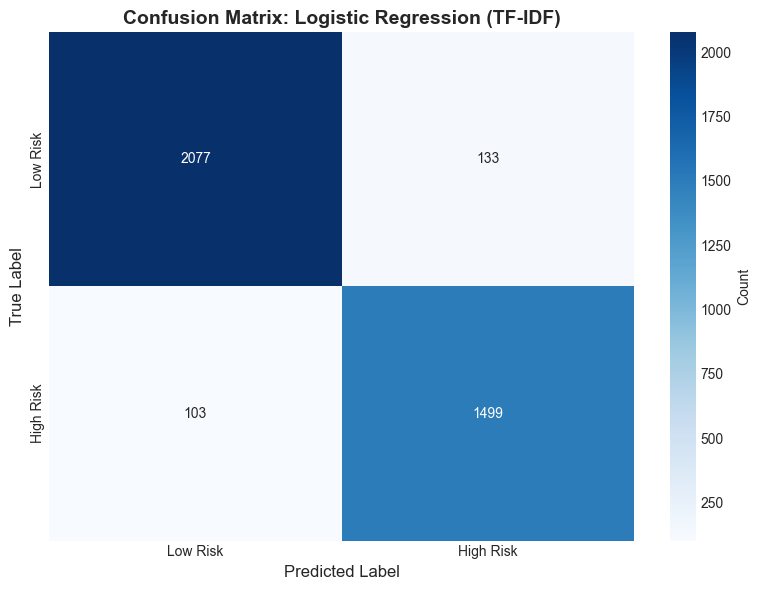


✅ Model saved to: ../models/reddit_tfidf_logistic_regression.pkl

📊 Top 20 High Risk Indicators (Positive Coefficients):
   migraine                      : +7.6573
   pain                          : +6.6045
   diabetes                      : +6.2210
   quit                          : +5.2837
   insulin                       : +5.1628
   smoking                       : +5.0557
   sober                         : +4.9241
   metformin                     : +4.5978
   diagnosed                     : +4.4763
   quitting                      : +4.3961
   diabetic                      : +4.1575
   spike                         : +4.0813
   anxiety                       : +3.8533
   smoke                         : +3.8258
   cgm                           : +3.7845
   health anxiety                : +3.6902
   weed                          : +3.4396
   drinking                      : +3.2842
   glucose                       : +3.2212
   pump                          : +3.1283

📊 Top 20 Low Risk

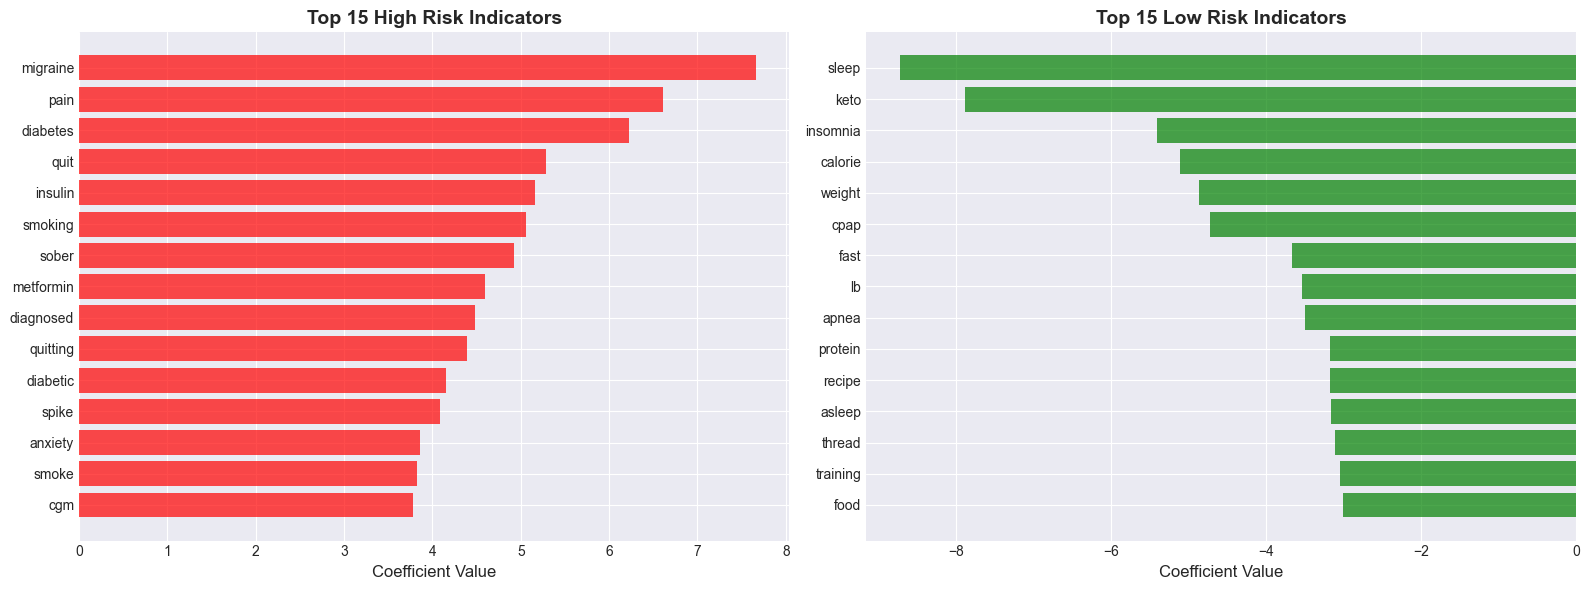

In [25]:
# Cell 23: TF-IDF + Logistic Regression
print("="*70)
print(" " * 10 + "TF-IDF BASELINE 1: LOGISTIC REGRESSION")
print("="*70)

from sklearn.linear_model import LogisticRegression

# Initialize model
lr_tfidf = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',
    solver='saga',  # Good for L1 regularization
    penalty='l2',
    C=1.0
)

# Train
print("\n🔄 Training Logistic Regression on TF-IDF features...")
lr_tfidf.fit(X_train_tfidf, y_train_text)
print("✅ Training complete!")

# Evaluate
lr_tfidf_metrics = evaluate_model(
    lr_tfidf,
    X_train_tfidf, y_train_text,
    X_test_tfidf, y_test_text,
    "Logistic Regression (TF-IDF)"
)

# Save model
joblib.dump(lr_tfidf, '../models/reddit_tfidf_logistic_regression.pkl')
print(f"\n✅ Model saved to: ../models/reddit_tfidf_logistic_regression.pkl")

# Feature importance (coefficients)
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = lr_tfidf.coef_[0]

# Top positive coefficients (high risk indicators)
top_positive_idx = coefficients.argsort()[-20:][::-1]
print(f"\n📊 Top 20 High Risk Indicators (Positive Coefficients):")
for idx in top_positive_idx:
    print(f"   {feature_names[idx]:30s}: {coefficients[idx]:+.4f}")

# Top negative coefficients (low risk indicators)
top_negative_idx = coefficients.argsort()[:20]
print(f"\n📊 Top 20 Low Risk Indicators (Negative Coefficients):")
for idx in top_negative_idx:
    print(f"   {feature_names[idx]:30s}: {coefficients[idx]:+.4f}")

# Visualize top features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# High risk features
top_pos_features = [feature_names[i] for i in top_positive_idx[:15]]
top_pos_coefs = [coefficients[i] for i in top_positive_idx[:15]]

axes[0].barh(range(len(top_pos_features)), top_pos_coefs, color='red', alpha=0.7)
axes[0].set_yticks(range(len(top_pos_features)))
axes[0].set_yticklabels(top_pos_features)
axes[0].set_xlabel('Coefficient Value', fontsize=12)
axes[0].set_title('Top 15 High Risk Indicators', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Low risk features
top_neg_features = [feature_names[i] for i in top_negative_idx[:15]]
top_neg_coefs = [coefficients[i] for i in top_negative_idx[:15]]

axes[1].barh(range(len(top_neg_features)), top_neg_coefs, color='green', alpha=0.7)
axes[1].set_yticks(range(len(top_neg_features)))
axes[1].set_yticklabels(top_neg_features)
axes[1].set_xlabel('Coefficient Value', fontsize=12)
axes[1].set_title('Top 15 Low Risk Indicators', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../reports/tfidf_lr_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

          TF-IDF BASELINE 2: RANDOM FOREST

🔄 Training Random Forest on TF-IDF features...
✅ Training complete!
                    EVALUATING: Random Forest (TF-IDF)

📊 Performance Metrics:
   Training Accuracy: 0.9277
   Test Accuracy: 0.9045
   Precision: 0.9092
   Recall: 0.9045
   F1-Score: 0.9050
   ROC-AUC: 0.9737

📋 Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.95      0.88      0.91      2210
   High Risk       0.85      0.94      0.89      1602

    accuracy                           0.90      3812
   macro avg       0.90      0.91      0.90      3812
weighted avg       0.91      0.90      0.91      3812



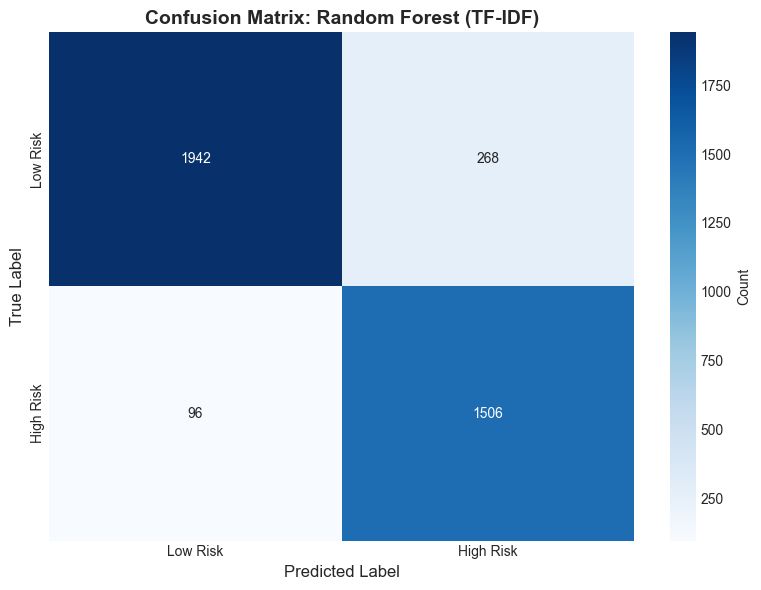


✅ Model saved to: ../models/reddit_tfidf_random_forest.pkl

📊 Top 20 Most Important Features (Random Forest):
   sleep                         : 0.035504
   quit                          : 0.028619
   calorie                       : 0.028063
   weight                        : 0.019647
   pain                          : 0.019470
   smoking                       : 0.019398
   protein                       : 0.016898
   migraine                      : 0.016128
   sober                         : 0.015301
   keto                          : 0.015175
   blood                         : 0.015028
   health anxiety                : 0.013382
   fat                           : 0.012904
   diabetes                      : 0.012845
   welcome                       : 0.012274
   quitting                      : 0.011451
   thread                        : 0.011109
   insulin                       : 0.010792
   smoke                         : 0.010742
   symptom                       : 0.010717


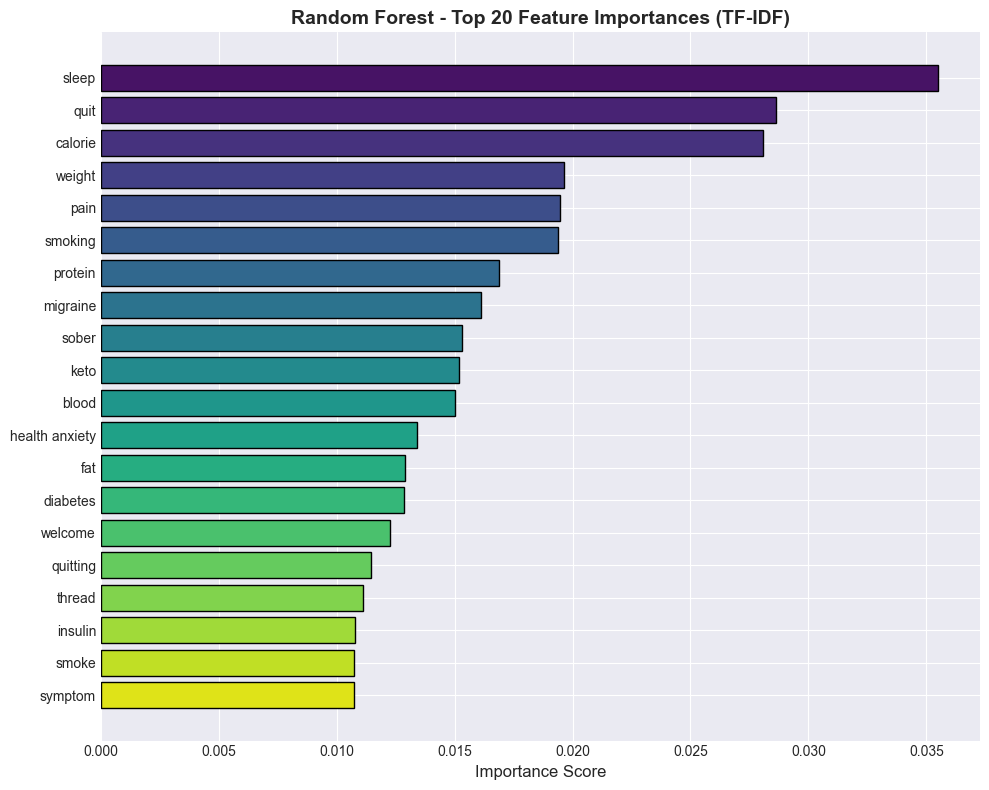

In [26]:
# Cell 24: TF-IDF + Random Forest
print("="*70)
print(" " * 10 + "TF-IDF BASELINE 2: RANDOM FOREST")
print("="*70)

from sklearn.ensemble import RandomForestClassifier

# Initialize model
rf_tfidf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Train
print("\n🔄 Training Random Forest on TF-IDF features...")
rf_tfidf.fit(X_train_tfidf, y_train_text)
print("✅ Training complete!")

# Evaluate
rf_tfidf_metrics = evaluate_model(
    rf_tfidf,
    X_train_tfidf, y_train_text,
    X_test_tfidf, y_test_text,
    "Random Forest (TF-IDF)"
)

# Save model
joblib.dump(rf_tfidf, '../models/reddit_tfidf_random_forest.pkl')
print(f"\n✅ Model saved to: ../models/reddit_tfidf_random_forest.pkl")

# Feature importance
feature_importances = rf_tfidf.feature_importances_
top_feature_idx = feature_importances.argsort()[-20:][::-1]

print(f"\n📊 Top 20 Most Important Features (Random Forest):")
for idx in top_feature_idx:
    print(f"   {feature_names[idx]:30s}: {feature_importances[idx]:.6f}")

# Visualize
plt.figure(figsize=(10, 8))
top_20_features = [feature_names[i] for i in top_feature_idx]
top_20_importances = [feature_importances[i] for i in top_feature_idx]

plt.barh(range(len(top_20_features)), top_20_importances, 
         color=sns.color_palette("viridis", 20), edgecolor='black')
plt.yticks(range(len(top_20_features)), top_20_features)
plt.xlabel('Importance Score', fontsize=12)
plt.title('Random Forest - Top 20 Feature Importances (TF-IDF)', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../reports/tfidf_rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

          TF-IDF BASELINE 3: NAIVE BAYES

🔄 Training Multinomial Naive Bayes on TF-IDF features...
✅ Training complete!
                    EVALUATING: Naive Bayes (TF-IDF)

📊 Performance Metrics:
   Training Accuracy: 0.8894
   Test Accuracy: 0.8754
   Precision: 0.8862
   Recall: 0.8754
   F1-Score: 0.8762
   ROC-AUC: 0.9623

📋 Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.95      0.83      0.89      2210
   High Risk       0.80      0.94      0.86      1602

    accuracy                           0.88      3812
   macro avg       0.87      0.88      0.87      3812
weighted avg       0.89      0.88      0.88      3812



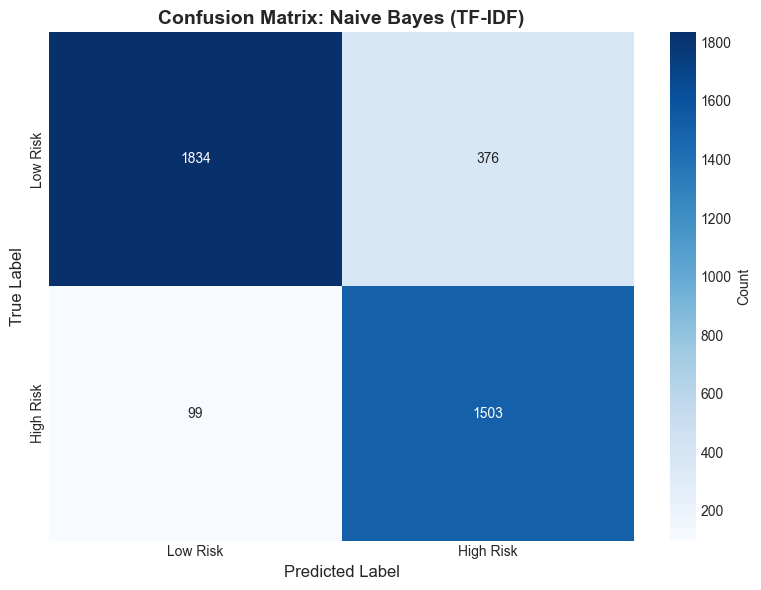


✅ Model saved to: ../models/reddit_tfidf_naive_bayes.pkl

📊 Most Indicative Features by Class:

LOW RISK:
   sleep                         : 0.003785
   like                          : 0.003600
   day                           : 0.002987
   time                          : 0.002645
   get                           : 0.002597
   weight                        : 0.002493
   week                          : 0.002398
   also                          : 0.002339
   feel                          : 0.002324
   know                          : 0.002196
   question                      : 0.002193
   would                         : 0.002177
   eat                           : 0.002070
   anyone                        : 0.002064
   make                          : 0.002057

HIGH RISK:
   day                           : 0.004129
   like                          : 0.003665
   year                          : 0.003604
   feel                          : 0.003395
   get                           : 0.003278
 

In [27]:
# Cell 25: TF-IDF + Multinomial Naive Bayes
print("="*70)
print(" " * 10 + "TF-IDF BASELINE 3: NAIVE BAYES")
print("="*70)

from sklearn.naive_bayes import MultinomialNB

# Initialize model
nb_tfidf = MultinomialNB(
    alpha=1.0,  # Laplace smoothing
    fit_prior=True
)

# Train
print("\n🔄 Training Multinomial Naive Bayes on TF-IDF features...")
nb_tfidf.fit(X_train_tfidf, y_train_text)
print("✅ Training complete!")

# Evaluate
nb_tfidf_metrics = evaluate_model(
    nb_tfidf,
    X_train_tfidf, y_train_text,
    X_test_tfidf, y_test_text,
    "Naive Bayes (TF-IDF)"
)

# Save model
joblib.dump(nb_tfidf, '../models/reddit_tfidf_naive_bayes.pkl')
print(f"\n✅ Model saved to: ../models/reddit_tfidf_naive_bayes.pkl")

# Feature log probabilities
feature_log_prob = nb_tfidf.feature_log_prob_

# Most indicative features for each class
print(f"\n📊 Most Indicative Features by Class:")

for class_idx, class_name in enumerate(['Low Risk', 'High Risk']):
    print(f"\n{class_name.upper()}:")
    top_idx = feature_log_prob[class_idx].argsort()[-15:][::-1]
    for idx in top_idx:
        print(f"   {feature_names[idx]:30s}: {np.exp(feature_log_prob[class_idx][idx]):.6f}")

          TF-IDF MODELS - PERFORMANCE SUMMARY

📊 TF-IDF Models Comparison Table:
                  model_name  train_accuracy  test_accuracy  precision  recall  f1_score  roc_auc
Logistic Regression (TF-IDF)          0.9600         0.9381     0.9384  0.9381    0.9382   0.9837
      Random Forest (TF-IDF)          0.9277         0.9045     0.9092  0.9045    0.9050   0.9737
        Naive Bayes (TF-IDF)          0.8894         0.8754     0.8862  0.8754    0.8762   0.9623


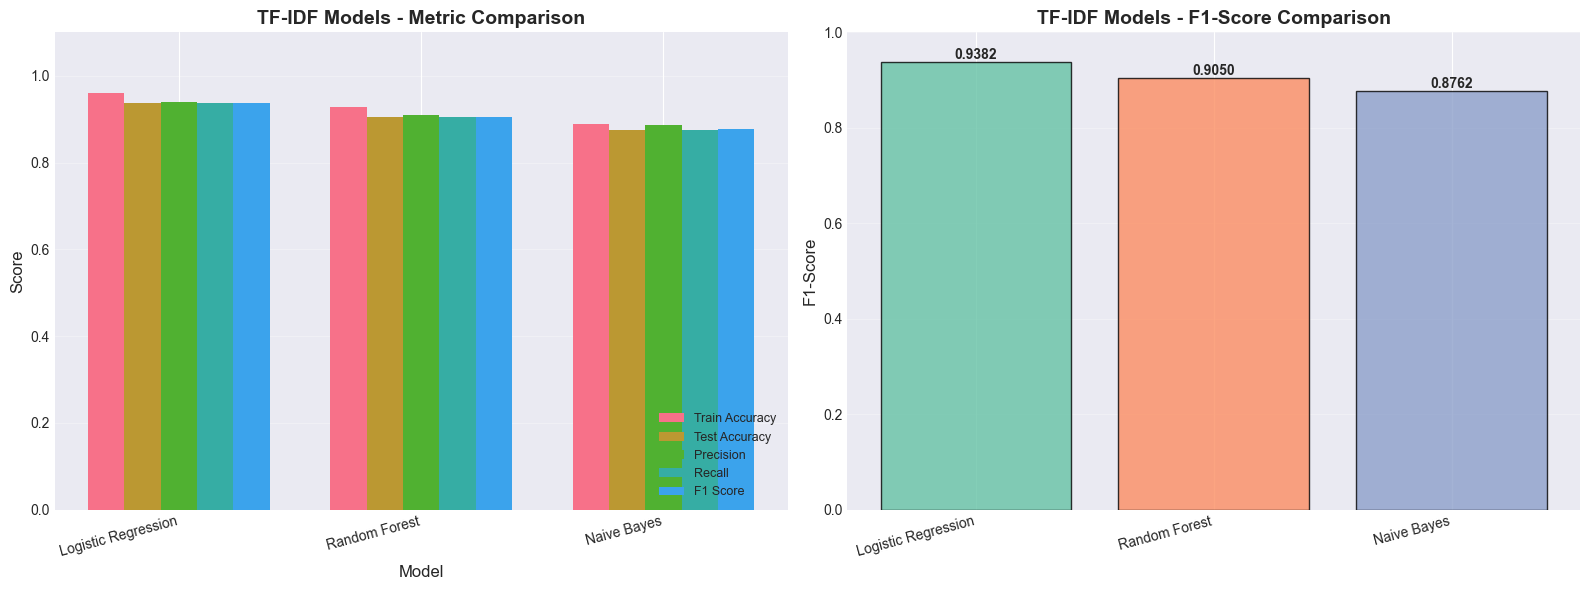


✅ TF-IDF summary saved to: ../results/tfidf_models_summary.csv

🏆 BEST TF-IDF MODEL:
   Model: Logistic Regression (TF-IDF)
   F1-Score: 0.9382

🔄 Running 5-Fold Cross-Validation on Best TF-IDF Model...

✅ Cross-Validation Results:
   Mean F1-Score: 0.9342 (+/- 0.0013)
   Individual Folds: [0.93181777 0.93450622 0.93585264 0.93443922 0.93447862]

✅ Best TF-IDF model saved as: ../models/best_tfidf_model.pkl


In [28]:
# Cell 26: TF-IDF Models Performance Summary
print("="*70)
print(" " * 10 + "TF-IDF MODELS - PERFORMANCE SUMMARY")
print("="*70)

# Compile metrics
tfidf_all_metrics = [lr_tfidf_metrics, rf_tfidf_metrics, nb_tfidf_metrics]

# Create summary DataFrame
tfidf_summary_df = pd.DataFrame(tfidf_all_metrics).round(4)

print("\n📊 TF-IDF Models Comparison Table:")
print("="*70)
print(tfidf_summary_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Metric comparison
metrics_to_plot = ['train_accuracy', 'test_accuracy', 'precision', 'recall', 'f1_score']
model_names = tfidf_summary_df['model_name'].tolist()

x = np.arange(len(model_names))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    offset = (i - 2) * width
    axes[0].bar(x + offset, tfidf_summary_df[metric], width, 
                label=metric.replace('_', ' ').title())

axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('TF-IDF Models - Metric Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([name.split('(')[0].strip() for name in model_names], 
                         rotation=15, ha='right')
axes[0].legend(loc='lower right', fontsize=9)
axes[0].set_ylim(0, 1.1)
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: F1-Score comparison (key metric)
f1_scores = tfidf_summary_df['f1_score'].tolist()
colors = sns.color_palette("Set2", len(model_names))

bars = axes[1].bar(range(len(model_names)), f1_scores, 
                   color=colors, edgecolor='black', alpha=0.8)
axes[1].set_xticks(range(len(model_names)))
axes[1].set_xticklabels([name.split('(')[0].strip() for name in model_names], 
                         rotation=15, ha='right')
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('TF-IDF Models - F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1.0)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.4f}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/tfidf_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save summary
tfidf_summary_df.to_csv('../results/tfidf_models_summary.csv', index=False)
print(f"\n✅ TF-IDF summary saved to: ../results/tfidf_models_summary.csv")

# Best TF-IDF model
best_tfidf_idx = tfidf_summary_df['f1_score'].idxmax()
best_tfidf_name = tfidf_summary_df.loc[best_tfidf_idx, 'model_name']
best_tfidf_f1 = tfidf_summary_df.loc[best_tfidf_idx, 'f1_score']

print(f"\n🏆 BEST TF-IDF MODEL:")
print(f"   Model: {best_tfidf_name}")
print(f"   F1-Score: {best_tfidf_f1:.4f}")

# Cross-validation on best model
print(f"\n🔄 Running 5-Fold Cross-Validation on Best TF-IDF Model...")
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_tfidf_model = lr_tfidf  # Adjust based on actual best

cv_scores = cross_val_score(best_tfidf_model, X_train_tfidf, y_train_text,
                             cv=cv, scoring='f1_weighted', n_jobs=-1)

print(f"\n✅ Cross-Validation Results:")
print(f"   Mean F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"   Individual Folds: {cv_scores}")

# Save best TF-IDF model
joblib.dump(best_tfidf_model, '../models/best_tfidf_model.pkl')
print(f"\n✅ Best TF-IDF model saved as: ../models/best_tfidf_model.pkl")

In [29]:
# Cell 27: Import SBERT Libraries
print("="*70)
print(" " * 10 + "SBERT + SVM ADVANCED MODELS - SETUP")
print("="*70)

# Check if sentence-transformers is installed
try:
    from sentence_transformers import SentenceTransformer
    print("✅ sentence-transformers already installed")
except ImportError:
    print("⚠️  Installing sentence-transformers...")
    import sys
    !{sys.executable} -m pip install sentence-transformers -q
    from sentence_transformers import SentenceTransformer
    print("✅ sentence-transformers installed successfully")

# Import SVM libraries
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler as SVMScaler
import time

print("\n✅ All SBERT libraries imported successfully!")

# Check CUDA availability (GPU acceleration)
import torch
if torch.cuda.is_available():
    device = 'cuda'
    print(f"\n🚀 GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA Version: {torch.version.cuda}")
else:
    device = 'cpu'
    print("\n💻 Using CPU (GPU not available)")
    print("   Note: Embedding generation will be slower on CPU")

print(f"\n📊 Dataset Info:")
print(f"   Training samples: {len(X_train_text):,}")
print(f"   Testing samples: {len(X_test_text):,}")

          SBERT + SVM ADVANCED MODELS - SETUP
⚠️  Installing sentence-transformers...


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ sentence-transformers installed successfully

✅ All SBERT libraries imported successfully!

💻 Using CPU (GPU not available)
   Note: Embedding generation will be slower on CPU

📊 Dataset Info:
   Training samples: 15,248
   Testing samples: 3,812


In [30]:
# Cell 28: Load SBERT Model
print("="*70)
print(" " * 15 + "LOADING SBERT MODEL")
print("="*70)

# Model selection - 'all-MiniLM-L6-v2' is fast and effective
# Alternative: 'all-mpnet-base-v2' (higher quality, slower)
model_name = 'all-MiniLM-L6-v2'

print(f"\n🔄 Loading SBERT model: {model_name}")
print("   (This may take a minute on first run...)\n")

start_time = time.time()

sbert_model = SentenceTransformer(model_name, device=device)

load_time = time.time() - start_time

print(f"\n✅ SBERT Model Loaded Successfully!")
print(f"   Model: {model_name}")
print(f"   Load time: {load_time:.2f} seconds")
print(f"   Max sequence length: {sbert_model.max_seq_length}")
print(f"   Embedding dimension: {sbert_model.get_sentence_embedding_dimension()}")
print(f"   Device: {device}")

# Model info
print(f"\n📊 Model Architecture:")
print(f"   Type: Sentence-BERT (Bi-Encoder)")
print(f"   Base Model: MiniLM")
print(f"   Training: Trained on 1B+ sentence pairs")
print(f"   Use Case: Semantic similarity and clustering")

               LOADING SBERT MODEL

🔄 Loading SBERT model: all-MiniLM-L6-v2
   (This may take a minute on first run...)



Loading weights: 100%|██████████| 103/103 [00:00<00:00, 457.54it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



✅ SBERT Model Loaded Successfully!
   Model: all-MiniLM-L6-v2
   Load time: 4.80 seconds
   Max sequence length: 256
   Embedding dimension: 384
   Device: cpu

📊 Model Architecture:
   Type: Sentence-BERT (Bi-Encoder)
   Base Model: MiniLM
   Training: Trained on 1B+ sentence pairs
   Use Case: Semantic similarity and clustering


In [31]:
# Cell 29: Generate Training Embeddings
print("="*70)
print(" " * 10 + "GENERATING SBERT EMBEDDINGS - TRAINING SET")
print("="*70)

print(f"\n🔄 Encoding {len(X_train_text):,} training texts...")
print("   (This will take 2-5 minutes depending on hardware...)\n")

start_time = time.time()

# Generate embeddings with progress bar
X_train_sbert = sbert_model.encode(
    X_train_text.tolist(),
    batch_size=32,              # Adjust based on available memory
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True   # L2 normalization for better SVM performance
)

encoding_time = time.time() - start_time

print(f"\n✅ Training Embeddings Generated!")
print(f"   Shape: {X_train_sbert.shape}")
print(f"   Dimension: {X_train_sbert.shape[1]}")
print(f"   Encoding time: {encoding_time:.2f} seconds")
print(f"   Speed: {len(X_train_text)/encoding_time:.1f} texts/second")
print(f"   Memory size: {X_train_sbert.nbytes / (1024**2):.2f} MB")

# Check embedding statistics
print(f"\n📊 Embedding Statistics:")
print(f"   Mean: {X_train_sbert.mean():.6f}")
print(f"   Std: {X_train_sbert.std():.6f}")
print(f"   Min: {X_train_sbert.min():.6f}")
print(f"   Max: {X_train_sbert.max():.6f}")

# Save embeddings (for future use without re-encoding)
np.save('../models/sbert_train_embeddings.npy', X_train_sbert)
print(f"\n✅ Training embeddings saved to: ../models/sbert_train_embeddings.npy")

          GENERATING SBERT EMBEDDINGS - TRAINING SET

🔄 Encoding 15,248 training texts...
   (This will take 2-5 minutes depending on hardware...)



Batches: 100%|██████████| 477/477 [04:13<00:00,  1.88it/s]



✅ Training Embeddings Generated!
   Shape: (15248, 384)
   Dimension: 384
   Encoding time: 254.71 seconds
   Speed: 59.9 texts/second
   Memory size: 22.34 MB

📊 Embedding Statistics:
   Mean: -0.000888
   Std: 0.051023
   Min: -0.275443
   Max: 0.284267

✅ Training embeddings saved to: ../models/sbert_train_embeddings.npy


In [32]:
# Cell 30: Generate Test Embeddings
print("="*70)
print(" " * 10 + "GENERATING SBERT EMBEDDINGS - TEST SET")
print("="*70)

print(f"\n🔄 Encoding {len(X_test_text):,} test texts...\n")

start_time = time.time()

X_test_sbert = sbert_model.encode(
    X_test_text.tolist(),
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

encoding_time = time.time() - start_time

print(f"\n✅ Test Embeddings Generated!")
print(f"   Shape: {X_test_sbert.shape}")
print(f"   Encoding time: {encoding_time:.2f} seconds")
print(f"   Speed: {len(X_test_text)/encoding_time:.1f} texts/second")

# Save test embeddings
np.save('../models/sbert_test_embeddings.npy', X_test_sbert)
print(f"\n✅ Test embeddings saved to: ../models/sbert_test_embeddings.npy")

# Sample embedding visualization
print(f"\n📝 Sample Embedding (first 10 dimensions):")
print(f"   Text: '{X_train_text[0][:80]}...'")
print(f"   Embedding: {X_train_sbert[0][:10]}")

# Verify embedding similarity (sanity check)
from sklearn.metrics.pairwise import cosine_similarity

# Compare first two training samples
sim_score = cosine_similarity(X_train_sbert[0:1], X_train_sbert[1:2])[0][0]
print(f"\n🔍 Sanity Check - Cosine Similarity:")
print(f"   Sample 1: '{X_train_text[0][:60]}...'")
print(f"   Sample 2: '{X_train_text[1][:60]}...'")
print(f"   Similarity: {sim_score:.4f}")

          GENERATING SBERT EMBEDDINGS - TEST SET

🔄 Encoding 3,812 test texts...



Batches: 100%|██████████| 120/120 [01:04<00:00,  1.86it/s]


✅ Test Embeddings Generated!
   Shape: (3812, 384)
   Encoding time: 64.60 seconds
   Speed: 59.0 texts/second

✅ Test embeddings saved to: ../models/sbert_test_embeddings.npy

📝 Sample Embedding (first 10 dimensions):
   Text: 'hello got diagnosed week ago come lower income country nepal affording cgm almos...'
   Embedding: [-0.02814315  0.00673017  0.0270817   0.02231842 -0.0131634   0.04654298
  0.01739872  0.0606955  -0.08557259 -0.03645961]

🔍 Sanity Check - Cosine Similarity:
   Sample 1: 'hello got diagnosed week ago come lower income country nepal...'
   Sample 2: 'i’m month sober lapse christmas party two week ago don’t kno...'
   Similarity: 0.3011


          SBERT MODEL 1: LINEAR SVM

🔄 Training Linear SVM on SBERT embeddings...
✅ Training complete! (1.30 seconds)

📊 Evaluating Linear SVM...

📊 Performance Metrics:
   Training Accuracy: 0.9356
   Test Accuracy: 0.9260
   Precision: 0.9263
   Recall: 0.9260
   F1-Score: 0.9261

📋 Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.94      0.93      0.94      2210
   High Risk       0.91      0.92      0.91      1602

    accuracy                           0.93      3812
   macro avg       0.92      0.93      0.92      3812
weighted avg       0.93      0.93      0.93      3812



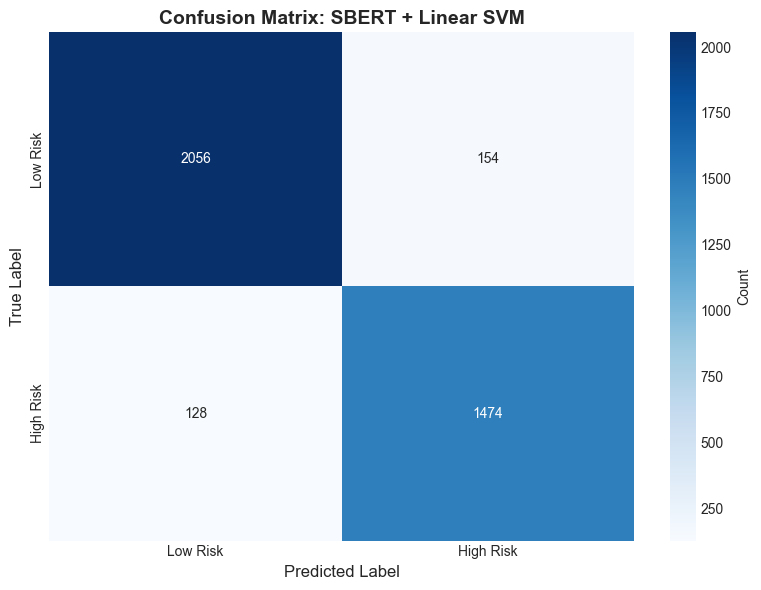


✅ Model saved to: ../models/sbert_linear_svm.pkl


In [33]:
# Cell 31: SBERT + Linear SVM
print("="*70)
print(" " * 10 + "SBERT MODEL 1: LINEAR SVM")
print("="*70)

from sklearn.svm import LinearSVC

# Initialize Linear SVM (faster than RBF for high-dimensional data)
svm_linear = LinearSVC(
    C=1.0,
    class_weight='balanced',
    max_iter=2000,
    random_state=42,
    dual=False  # Recommended when n_samples > n_features
)

# Train
print("\n🔄 Training Linear SVM on SBERT embeddings...")
start_time = time.time()

svm_linear.fit(X_train_sbert, y_train_text)

train_time = time.time() - start_time
print(f"✅ Training complete! ({train_time:.2f} seconds)")

# For evaluate_model function, LinearSVC doesn't have predict_proba
# We need to wrap it or modify evaluation
# Let's create predictions manually for evaluation

print("\n📊 Evaluating Linear SVM...")

# Training predictions
y_train_pred_svm_linear = svm_linear.predict(X_train_sbert)
train_accuracy = accuracy_score(y_train_text, y_train_pred_svm_linear)

# Test predictions
y_test_pred_svm_linear = svm_linear.predict(X_test_sbert)
test_accuracy = accuracy_score(y_test_text, y_test_pred_svm_linear)

# Detailed metrics
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test_text, y_test_pred_svm_linear, average='weighted'
)

print(f"\n📊 Performance Metrics:")
print(f"   Training Accuracy: {train_accuracy:.4f}")
print(f"   Test Accuracy: {test_accuracy:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall: {recall:.4f}")
print(f"   F1-Score: {f1:.4f}")

# Classification Report
print(f"\n📋 Classification Report:")
print(classification_report(y_test_text, y_test_pred_svm_linear, 
                           target_names=['Low Risk', 'High Risk']))

# Confusion Matrix
cm = confusion_matrix(y_test_text, y_test_pred_svm_linear)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix: SBERT + Linear SVM', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('../reports/cm_sbert_linear_svm.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model
joblib.dump(svm_linear, '../models/sbert_linear_svm.pkl')
print(f"\n✅ Model saved to: ../models/sbert_linear_svm.pkl")

# Store metrics
svm_linear_metrics = {
    'model_name': 'SBERT + Linear SVM',
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'roc_auc': None,  # LinearSVC doesn't support predict_proba
    'train_time': train_time
}

          SBERT MODEL 2: RBF SVM

🔄 Training RBF SVM on SBERT embeddings...
   (This may take 3-5 minutes for large datasets...)


✅ Training complete! (88.94 seconds)
                    EVALUATING: SBERT + RBF SVM

📊 Performance Metrics:
   Training Accuracy: 0.9757
   Test Accuracy: 0.9467
   Precision: 0.9469
   Recall: 0.9467
   F1-Score: 0.9468
   ROC-AUC: 0.9870

📋 Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.96      0.95      0.95      2210
   High Risk       0.93      0.94      0.94      1602

    accuracy                           0.95      3812
   macro avg       0.94      0.95      0.95      3812
weighted avg       0.95      0.95      0.95      3812



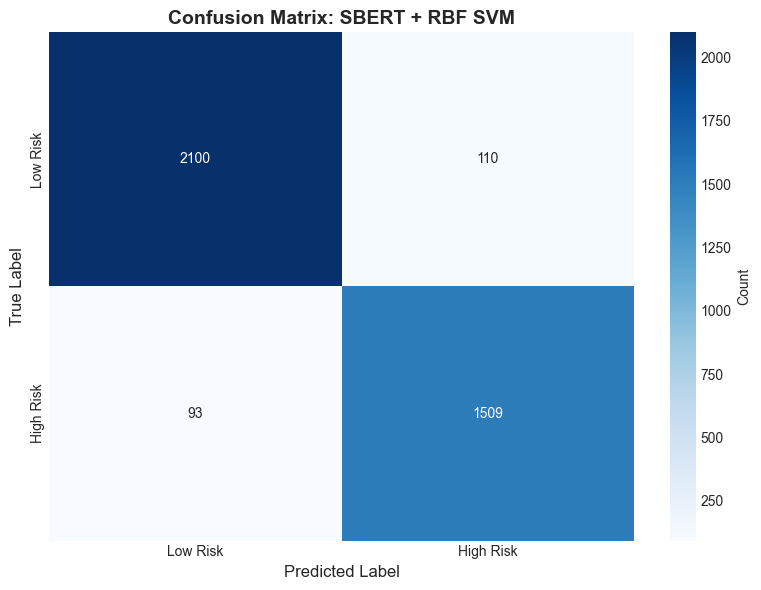


✅ Model saved to: ../models/sbert_rbf_svm.pkl

📊 Model Details:
   Support Vectors: [2021 1622]
   Total Support Vectors: 3643
   Kernel: rbf
   Gamma: scale


In [34]:
# Cell 32: SBERT + RBF SVM (with probability estimates)
print("="*70)
print(" " * 10 + "SBERT MODEL 2: RBF SVM")
print("="*70)

from sklearn.svm import SVC

# Initialize RBF SVM
svm_rbf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    probability=True,  # Enable probability estimates
    random_state=42,
    cache_size=500  # MB of cache
)

# Train
print("\n🔄 Training RBF SVM on SBERT embeddings...")
print("   (This may take 3-5 minutes for large datasets...)\n")

start_time = time.time()

svm_rbf.fit(X_train_sbert, y_train_text)

train_time = time.time() - start_time
print(f"\n✅ Training complete! ({train_time:.2f} seconds)")

# Evaluate using our standard function
svm_rbf_metrics = evaluate_model(
    svm_rbf,
    X_train_sbert, y_train_text,
    X_test_sbert, y_test_text,
    "SBERT + RBF SVM"
)

# Add training time
svm_rbf_metrics['train_time'] = train_time

# Save model
joblib.dump(svm_rbf, '../models/sbert_rbf_svm.pkl')
print(f"\n✅ Model saved to: ../models/sbert_rbf_svm.pkl")

# Additional info
print(f"\n📊 Model Details:")
print(f"   Support Vectors: {svm_rbf.n_support_}")
print(f"   Total Support Vectors: {svm_rbf.support_vectors_.shape[0]}")
print(f"   Kernel: {svm_rbf.kernel}")
print(f"   Gamma: {svm_rbf.gamma}")

          HYPERPARAMETER TUNING - SBERT + SVM

🔄 Performing Grid Search (This may take 10-15 minutes)...
   Using 3-fold cross-validation

Fitting 3 folds for each of 12 candidates, totalling 36 fits

✅ Grid Search Complete! (23.0 minutes)

🏆 Best Parameters:
   C: 10.0
   gamma: scale
   kernel: rbf

📊 Best Cross-Validation F1-Score: 0.9472
                    EVALUATING: SBERT + SVM (Tuned)

📊 Performance Metrics:
   Training Accuracy: 0.9998
   Test Accuracy: 0.9494
   Precision: 0.9494
   Recall: 0.9494
   F1-Score: 0.9494
   ROC-AUC: 0.9883

📋 Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.96      0.96      0.96      2210
   High Risk       0.94      0.94      0.94      1602

    accuracy                           0.95      3812
   macro avg       0.95      0.95      0.95      3812
weighted avg       0.95      0.95      0.95      3812



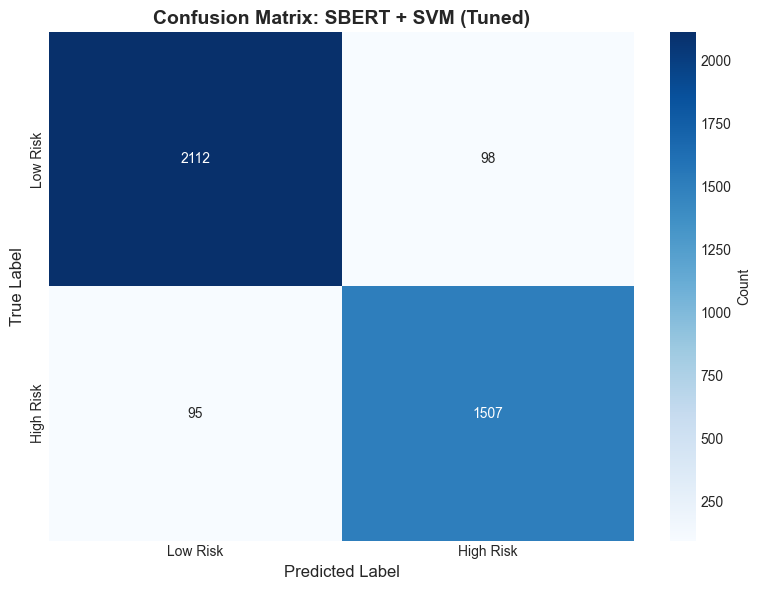


✅ Tuned model saved to: ../models/sbert_svm_tuned.pkl

✅ Grid search results saved to: ../results/sbert_svm_grid_search.csv


In [35]:
# Cell 33: Grid Search for Optimal SVM Hyperparameters
print("="*70)
print(" " * 10 + "HYPERPARAMETER TUNING - SBERT + SVM")
print("="*70)

print("\n🔄 Performing Grid Search (This may take 10-15 minutes)...")
print("   Using 3-fold cross-validation\n")

# Define parameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    SVC(class_weight='balanced', probability=True, random_state=42, cache_size=500),
    param_grid,
    cv=3,  # 3-fold CV for speed
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

# Fit
start_time = time.time()
grid_search.fit(X_train_sbert, y_train_text)
search_time = time.time() - start_time

print(f"\n✅ Grid Search Complete! ({search_time/60:.1f} minutes)")

# Best parameters
print(f"\n🏆 Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📊 Best Cross-Validation F1-Score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
svm_tuned = grid_search.best_estimator_

# Evaluate tuned model
svm_tuned_metrics = evaluate_model(
    svm_tuned,
    X_train_sbert, y_train_text,
    X_test_sbert, y_test_text,
    "SBERT + SVM (Tuned)"
)

# Save tuned model
joblib.dump(svm_tuned, '../models/sbert_svm_tuned.pkl')
print(f"\n✅ Tuned model saved to: ../models/sbert_svm_tuned.pkl")

# Save grid search results
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results.to_csv('../results/sbert_svm_grid_search.csv', index=False)
print(f"\n✅ Grid search results saved to: ../results/sbert_svm_grid_search.csv")

          SBERT EMBEDDINGS - DIMENSIONALITY REDUCTION

🔄 Running t-SNE on 2000 samples...
   (This may take 2-3 minutes...)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 3.317s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000001
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.124252
[t-SNE] KL divergence after 1000 iterations: 1.407626

✅ t-SNE Complete! (11.0 seconds)


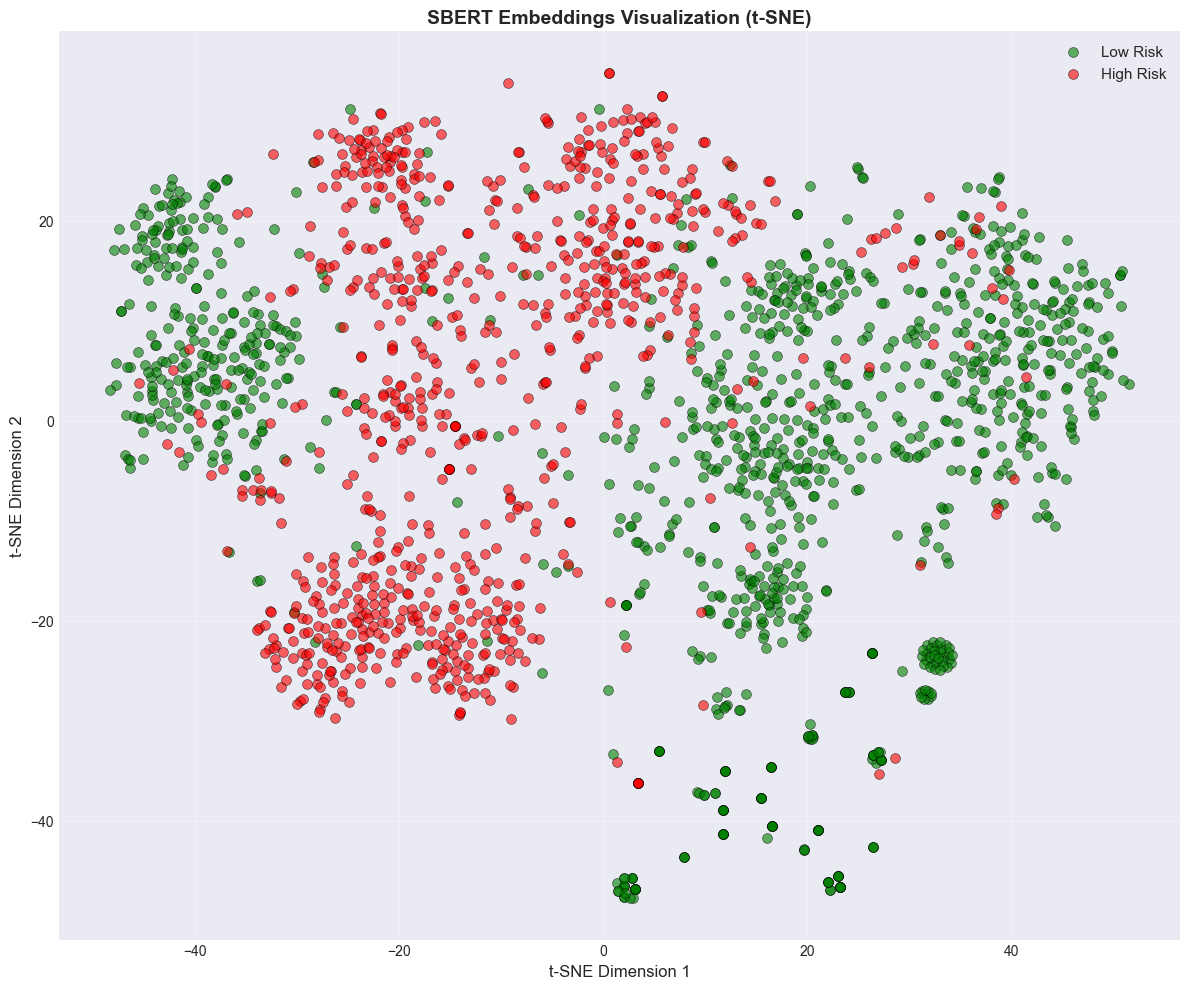


✅ Visualization saved to: ../reports/sbert_tsne_visualization.png

📊 Silhouette Score (clustering quality): 0.1521
   (Range: -1 to 1, higher is better)


In [40]:
# Cell 34: Visualize SBERT Embeddings with t-SNE
print("="*70)
print(" " * 10 + "SBERT EMBEDDINGS - DIMENSIONALITY REDUCTION")
print("="*70)

from sklearn.manifold import TSNE

# Use subset for faster visualization (full dataset would be slow)
n_samples_viz = 2000
sample_indices = np.random.choice(len(X_train_sbert), n_samples_viz, replace=False)

X_sample = X_train_sbert[sample_indices]
y_sample = y_train_text[sample_indices]

print(f"\n🔄 Running t-SNE on {n_samples_viz} samples...")
print("   (This may take 2-3 minutes...)\n")

# Apply t-SNE (FIXED: n_iter → max_iter for newer scikit-learn)
tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    max_iter=1000,  # FIXED: Changed from n_iter to max_iter
    verbose=1,
    n_jobs=-1  # Use all CPU cores for faster computation
)

start_time = time.time()
embeddings_2d = tsne.fit_transform(X_sample)
tsne_time = time.time() - start_time

print(f"\n✅ t-SNE Complete! ({tsne_time:.1f} seconds)")

# Visualize
fig, ax = plt.subplots(figsize=(12, 10))

# Plot by risk label
colors = ['green', 'red']
labels = ['Low Risk', 'High Risk']

for risk_level in [0, 1]:
    mask = y_sample == risk_level
    ax.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
              c=colors[risk_level], label=labels[risk_level],
              alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title('SBERT Embeddings Visualization (t-SNE)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/sbert_tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Visualization saved to: ../reports/sbert_tsne_visualization.png")

# Clustering quality metric
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(embeddings_2d, y_sample)
print(f"\n📊 Silhouette Score (clustering quality): {silhouette:.4f}")
print("   (Range: -1 to 1, higher is better)")

In [37]:
# Cell 35: Semantic Similarity Examples
print("="*70)
print(" " * 10 + "SEMANTIC SIMILARITY ANALYSIS")
print("="*70)

from sklearn.metrics.pairwise import cosine_similarity

# Find most similar pairs across risk categories
print("\n🔍 Finding semantically similar posts across risk levels...\n")

# Select sample posts from each risk level
low_risk_indices = np.where(y_train_text == 0)[0][:100]
high_risk_indices = np.where(y_train_text == 1)[0][:100]

# Compute similarity matrix
similarity_matrix = cosine_similarity(
    X_train_sbert[low_risk_indices],
    X_train_sbert[high_risk_indices]
)

# Find top 5 most similar cross-category pairs
top_pairs = []
for i in range(len(low_risk_indices)):
    for j in range(len(high_risk_indices)):
        top_pairs.append({
            'low_idx': low_risk_indices[i],
            'high_idx': high_risk_indices[j],
            'similarity': similarity_matrix[i, j]
        })

top_pairs_df = pd.DataFrame(top_pairs).nlargest(5, 'similarity')

print("📊 Top 5 Most Similar Post Pairs (Low Risk ↔ High Risk):")
print("="*70)

for idx, row in top_pairs_df.iterrows():
    low_idx = int(row['low_idx'])
    high_idx = int(row['high_idx'])
    sim = row['similarity']
    
    print(f"\nSimilarity: {sim:.4f}")
    print(f"Low Risk Post: '{X_train_text[low_idx][:100]}...'")
    print(f"High Risk Post: '{X_train_text[high_idx][:100]}...'")
    print("-"*70)

# Analyze average within-class vs cross-class similarity
low_low_sim = cosine_similarity(X_train_sbert[low_risk_indices]).mean()
high_high_sim = cosine_similarity(X_train_sbert[high_risk_indices]).mean()
cross_sim = similarity_matrix.mean()

print(f"\n📊 Average Similarity Scores:")
print(f"   Within Low Risk class: {low_low_sim:.4f}")
print(f"   Within High Risk class: {high_high_sim:.4f}")
print(f"   Between classes: {cross_sim:.4f}")
print(f"\n   Interpretation: {'Good separation' if (low_low_sim - cross_sim) > 0.1 else 'Moderate separation'}")

          SEMANTIC SIMILARITY ANALYSIS

🔍 Finding semantically similar posts across risk levels...

📊 Top 5 Most Similar Post Pairs (Low Risk ↔ High Risk):

Similarity: 0.6288
Low Risk Post: 'started exactly day ago yesterday went doctor told prediabeties successfully reversed top lost pound...'
High Risk Post: 'august day birthday diagnosed type diabetes believe hbac blood sugar doctor’s office getting super s...'
----------------------------------------------------------------------

Similarity: 0.6248
Low Risk Post: 'feel tired exhausted sleeping lucky get hour week sleep tried literally everything… hour meditation ...'
High Risk Post: 'felt alone started smoking weed cope isolation negative selftalk tried quit multiple time longest st...'
----------------------------------------------------------------------

Similarity: 0.6190
Low Risk Post: 'hey may long one thanks whoever stick around read give advicecomments i’ve struggled binge eating em...'
High Risk Post: 'august day birthda

          SBERT MODELS - PERFORMANCE SUMMARY

📊 SBERT Models Comparison Table:
         model_name  train_accuracy  test_accuracy  precision  recall  f1_score  roc_auc  train_time
 SBERT + Linear SVM          0.9356         0.9260     0.9263  0.9260    0.9261      NaN      1.2974
    SBERT + RBF SVM          0.9757         0.9467     0.9469  0.9467    0.9468   0.9870     88.9401
SBERT + SVM (Tuned)          0.9998         0.9494     0.9494  0.9494    0.9494   0.9883         NaN


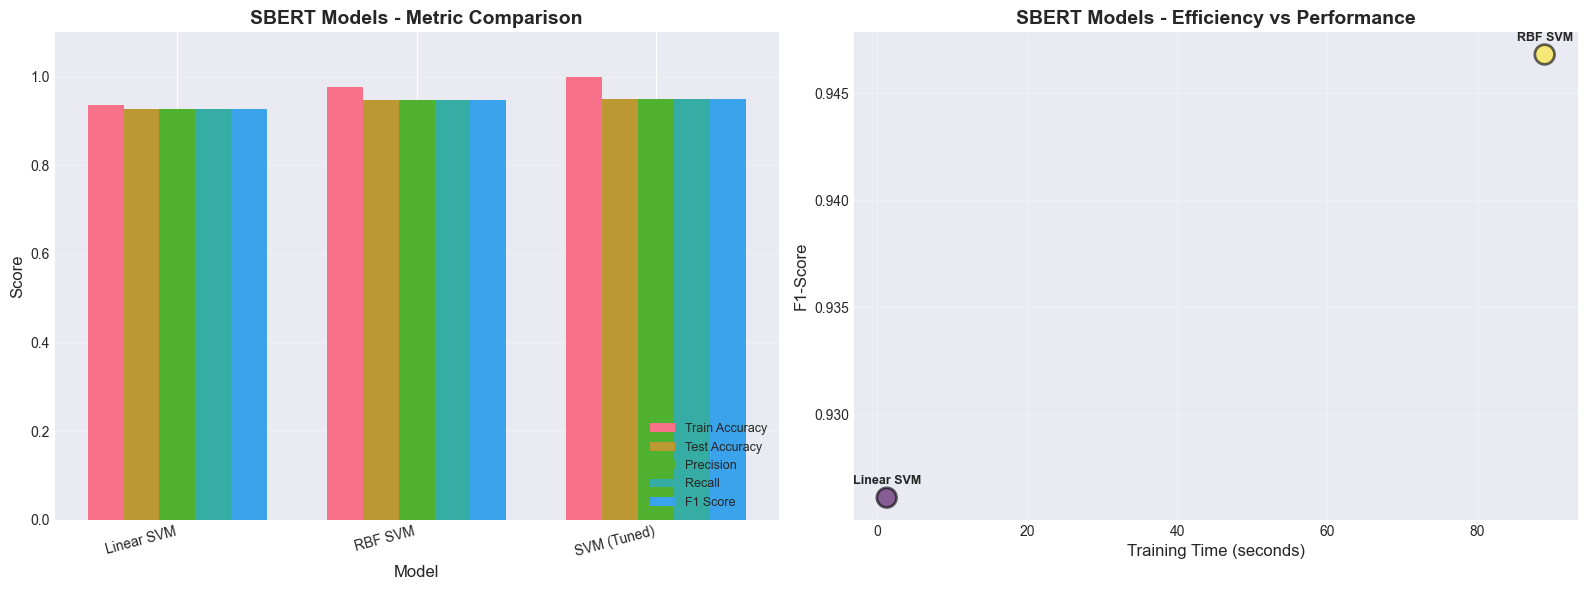


✅ SBERT summary saved to: ../results/sbert_models_summary.csv

🏆 BEST SBERT MODEL:
   Model: SBERT + SVM (Tuned)
   F1-Score: 0.9494
   Training Time: nans

✅ Best SBERT model saved as: ../models/best_sbert_model.pkl


In [39]:
# Cell 36: SBERT Models Summary
print("="*70)
print(" " * 10 + "SBERT MODELS - PERFORMANCE SUMMARY")
print("="*70)

# Compile all SBERT metrics
sbert_all_metrics = [svm_linear_metrics, svm_rbf_metrics, svm_tuned_metrics]

# Create summary DataFrame
sbert_summary_df = pd.DataFrame(sbert_all_metrics).round(4)

print("\n📊 SBERT Models Comparison Table:")
print("="*70)
print(sbert_summary_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Metric comparison
metrics_to_plot = ['train_accuracy', 'test_accuracy', 'precision', 'recall', 'f1_score']
model_names = sbert_summary_df['model_name'].tolist()

x = np.arange(len(model_names))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    offset = (i - 2) * width
    axes[0].bar(x + offset, sbert_summary_df[metric], width,
                label=metric.replace('_', ' ').title())

axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('SBERT Models - Metric Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([name.replace('SBERT + ', '') for name in model_names],
                        rotation=15, ha='right')
axes[0].legend(loc='lower right', fontsize=9)
axes[0].set_ylim(0, 1.1)
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Training time vs F1-Score
train_times = sbert_summary_df['train_time'].tolist()
f1_scores = sbert_summary_df['f1_score'].tolist()

scatter = axes[1].scatter(train_times, f1_scores, s=200, alpha=0.6,
                          c=range(len(model_names)), cmap='viridis',
                          edgecolors='black', linewidth=2)

for i, name in enumerate(model_names):
    axes[1].annotate(name.replace('SBERT + ', ''), 
                    (train_times[i], f1_scores[i]),
                    textcoords="offset points", xytext=(0,10),
                    ha='center', fontsize=9, fontweight='bold')

axes[1].set_xlabel('Training Time (seconds)', fontsize=12)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('SBERT Models - Efficiency vs Performance', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/sbert_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save summary
sbert_summary_df.to_csv('../results/sbert_models_summary.csv', index=False)
print(f"\n✅ SBERT summary saved to: ../results/sbert_models_summary.csv")

# Best SBERT model
best_sbert_idx = sbert_summary_df['f1_score'].idxmax()
best_sbert_name = sbert_summary_df.loc[best_sbert_idx, 'model_name']
best_sbert_f1 = sbert_summary_df.loc[best_sbert_idx, 'f1_score']

print(f"\n🏆 BEST SBERT MODEL:")
print(f"   Model: {best_sbert_name}")
print(f"   F1-Score: {best_sbert_f1:.4f}")
print(f"   Training Time: {sbert_summary_df.loc[best_sbert_idx, 'train_time']:.2f}s")

# Save best SBERT model reference
best_sbert_model = svm_tuned  # Adjust based on actual best
joblib.dump(best_sbert_model, '../models/best_sbert_model.pkl')
print(f"\n✅ Best SBERT model saved as: ../models/best_sbert_model.pkl")